## XGBoost ML-Model. 

###### A. part of Notebook is regional learning with the IT_AT/WGMS dataset. B. part is transfer learning with Swiss/GLAMOS train set and IT_AT/WGMS test set

### Setting Up:

In [1]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
from calendar import month_abbr
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import massbalancemachine as mbm
from collections import defaultdict
import logging
import numpy as np

from scripts.helpers import *
from scripts.italy_austria_preprocess import *
from scripts.plots import *
from scripts.config_IT_AT import *
from scripts.xgb_helpers import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

cfg = mbm.ItalyAustriaConfig(dataPath='/home/mburlet/scratch/data/DATA_MB/WGMS/IT_AT/')

In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)
colors = get_cmap_hex(cm.batlow, 10)
color_dark_blue = colors[0]
color_pink = '#c51b7d'
color_orange = '#FFA500'



vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect", # OGGM
    "slope", # OGGM
    "hugonnet_dhdt",  # OGGM
    "consensus_ice_thickness",  # OGGM
]

#### A.1. Read in stake data from preprocess, transform to monthly and add ERA5Land data

###### Load csv into df

In [3]:
data_wgms = pd.read_csv(cfg.dataPath + path_PMB_WGMS_csv + 'IT_AT_wgms_dataset_all_oggm.csv')

print('Number of glaciers:', len(data_wgms['GLACIER'].unique()))
print('Number of winter, summer and annual samples:', len(data_wgms[data_wgms.PERIOD == 'annual']) + len(data_wgms[data_wgms.PERIOD == 'winter']) + len(data_wgms[data_wgms.PERIOD == 'summer']))
print('Number of annual samples:',
      len(data_wgms[data_wgms.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_wgms[data_wgms.PERIOD == 'winter']))
print('Number of summer samples:',
      len(data_wgms[data_wgms.PERIOD == 'summer']))

data_wgms.columns

Number of glaciers: 24
Number of winter, summer and annual samples: 5086
Number of annual samples: 2872
Number of winter samples: 1548
Number of summer samples: 666


Index(['POINT_ID', 'POINT_LAT', 'POINT_LON', 'POINT_ELEVATION', 'FROM_DATE',
       'TO_DATE', 'POINT_BALANCE', 'GLACIER', 'PERIOD', 'RGIId', 'YEAR',
       'DATA_MODIFICATION', 'aspect', 'slope', 'topo', 'hugonnet_dhdt',
       'consensus_ice_thickness'],
      dtype='object')

###### Transform into monthly and add ERA5Land

In [4]:
data_wgms_test = data_wgms.copy()

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_WGMS_csv,
    'era5_climate_data': '/home/mburlet/scratch/data/DATA_MB/GLACIOCLIM/ERA5Land/raw/era5_monthly_averaged_data_Alps.nc',
    'geopotential_data': '/home/mburlet/scratch/data/DATA_MB/GLACIOCLIM/ERA5Land/raw/era5_geopotential_pressure_Alps.nc'
}

RUN = True
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_wgms_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file= 'IT_AT_wgms_dataset_monthly_full.csv')
data_monthly = dataloader_gl.data

display(data_monthly.head(2))

2025-06-11 12:03:29,322 - INFO - Number of annual and seasonal samples: 5086
2025-06-11 12:03:29,326 - INFO - Running on 24 glaciers:
['GOLDBERG K.' 'HINTEREIS F.' 'JAMTAL F.' 'KESSELWAND F.' 'KLEINFLEISS K.'
 'OE. WURTEN K.' 'VERNAGT F.' 'CARESER'
 'MALAVALLE (VEDR. DI) / UEBELTALF.' 'PENDENTE (VEDR.) / HANGENDERF.'
 'RIES OCC. (VEDR. DI) / RIESERF. WESTL.' 'GRAND ETRET' 'HALLSTAETTER G.'
 'VENEDIGER K.' 'ZETTALUNITZ/MULLWITZ K.' 'CIARDONEY'
 'FONTANA BIANCA / WEISSBRUNNF.' 'LUNGA (VEDRETTA) / LANGENF.'
 'CAMPO SETT.' 'LUPO' 'SURETTA MERIDIONALE' 'CARESER OCCIDENTALE'
 'CARESER ORIENTALE' 'CARESER CENTRALE']
2025-06-11 12:03:29,344 - INFO - Number of annual samples: 2872
2025-06-11 12:03:29,346 - INFO - Number of winter samples: 1548
2025-06-11 12:03:29,347 - INFO - Number of summer samples: 666
2025-06-11 12:03:29,348 - INFO - Adding climate features...
2025-06-11 12:03:33,635 - INFO - Converting to monthly resolution...
2025-06-11 12:03:46,375 - INFO - Number of monthly rows: 50833


YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
0  2020  12.965073  47.041127          0.276       2005.391746   
1  2020  12.965073  47.041127          0.276       2005.391746   

   ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
0            694.608254           2700.0  RGI60-11.00289   
1            694.608254           2700.0  RGI60-11.00289   

                    POINT_ID  ID  ...  consensus_ice_thickness       t2m  \
0  GOLDBERG K._2020_43346_AT   0  ...                48.199932  4.489166   
1  GOLDBERG K._2020_43346_AT   0  ...                48.199932 -2.252045   

         tp       slhf       sshf       ssrd       fal        str       u10  \
0  0.003263 -2294156.0 -1238456.0  9166658.0  0.229964 -3531426.0  0.265247   
1  0.011189  -350702.0  -297682.0  5373324.0  0.610374 -2029100.0  0.098144   

        v10  
0  0.430276  
1  0.601274  

[2 rows x 27 columns]

#### A.2. Dataset statistics

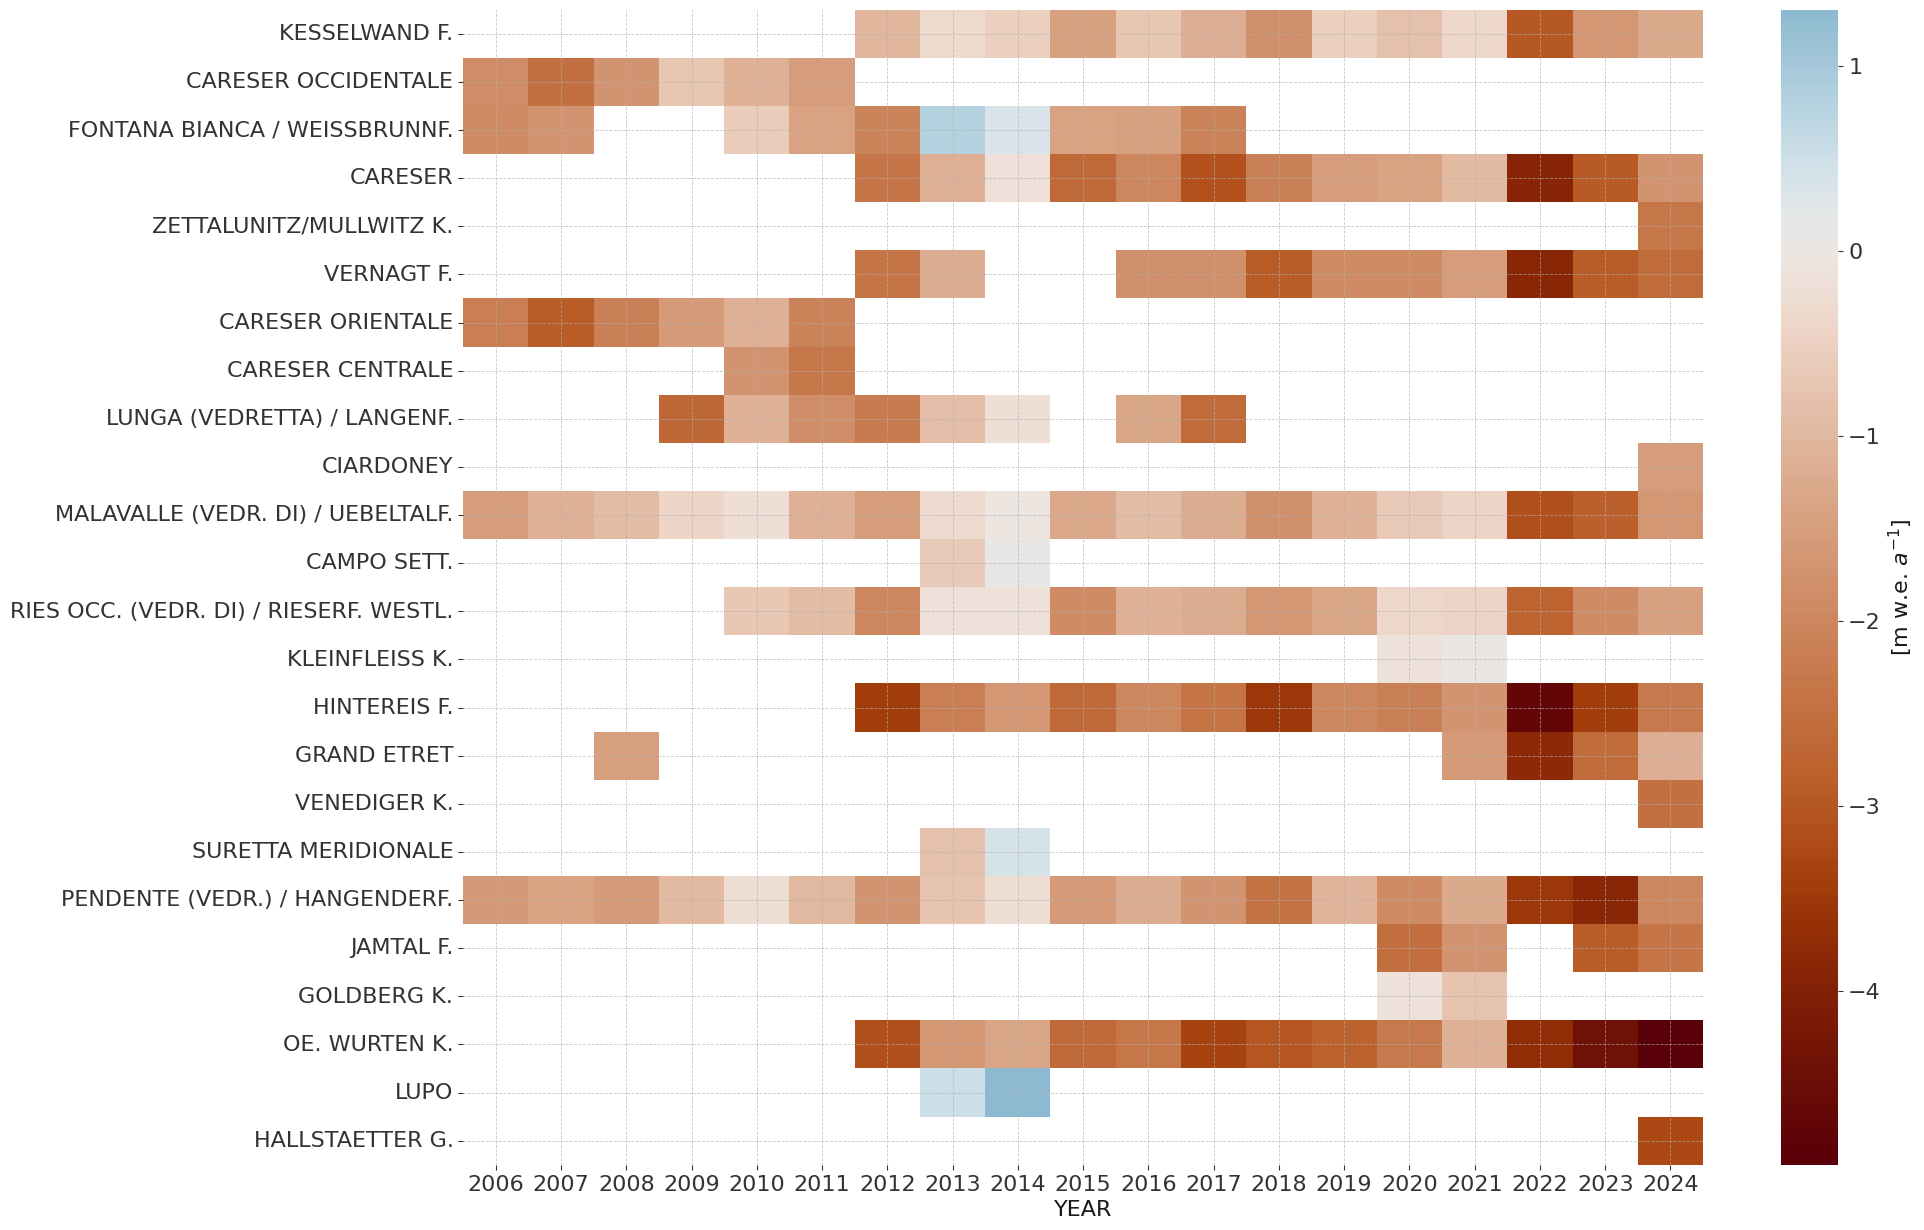

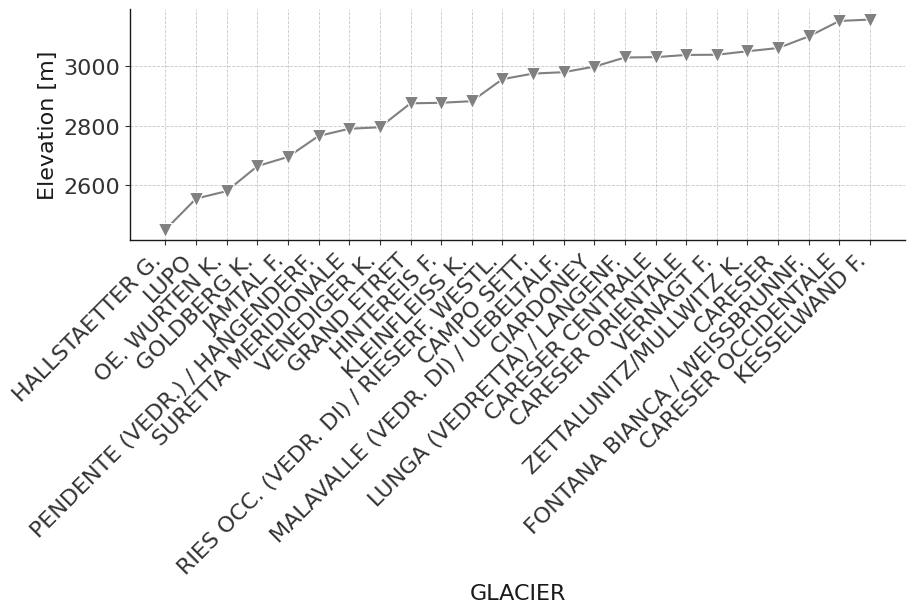

In [5]:
plotHeatmap(data_monthly, period='annual', plot_elevation=True)

Text(0.5, 1.0, 'Number of measurements per year for all glaciers')

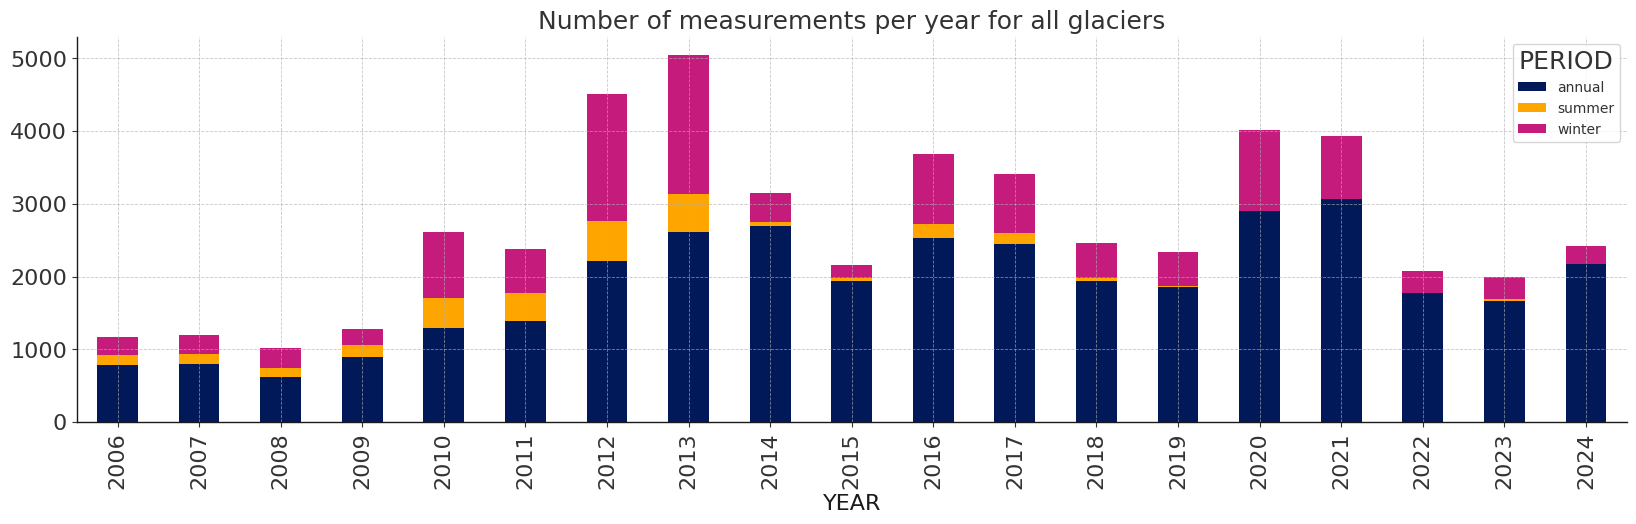

In [6]:
data_monthly.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar',
    stacked=True,
    figsize=(20, 5),
    color=[color_dark_blue, color_orange, color_pink])
plt.title('Number of measurements per year for all glaciers')

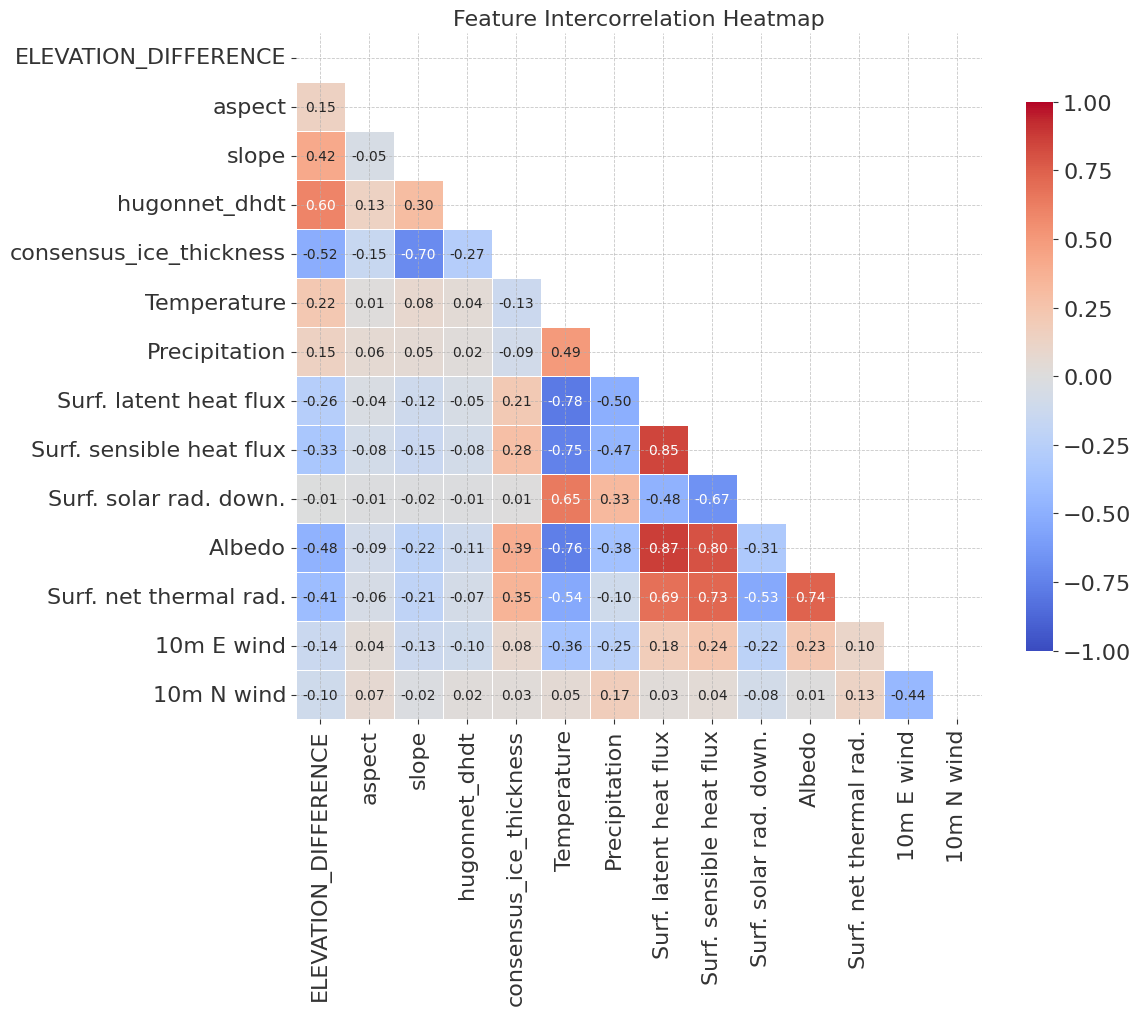

In [7]:
# Plot feature intercorrelation
plot_feature_correlation(dataloader_gl.data)

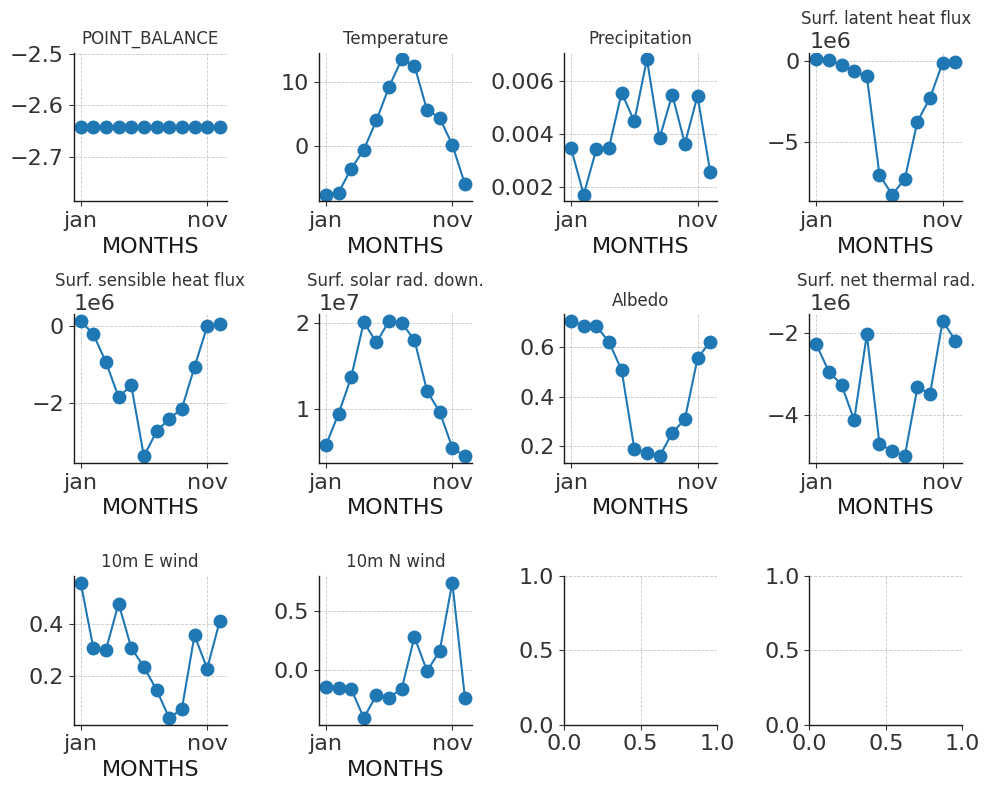

In [8]:
# Sanity check of variables:
df = dataloader_gl.data
var_to_plot = ['POINT_BALANCE'] + vois_climate
df = df[(df.GLACIER == 'OE. WURTEN K.') & (df.YEAR == 2015)].groupby(
    ['MONTHS'])[var_to_plot].mean().reset_index()
df['month_nb'] = df.MONTHS.apply(
    lambda x: list(month_abbr).index(x.capitalize()))
df.sort_values(by='month_nb', inplace=True)
fig, ax = plt.subplots(3, 4, figsize=(10, 8))

for i, var in enumerate(var_to_plot):
    df.plot(x='MONTHS', y=var, marker='o', ax=ax.flatten()[i], legend=False)
    if var in vois_climate_long_name.keys():
        ax.flatten()[i].set_title(vois_climate_long_name[var], fontsize=12)
    else:
        ax.flatten()[i].set_title(var, fontsize=12)
plt.tight_layout()

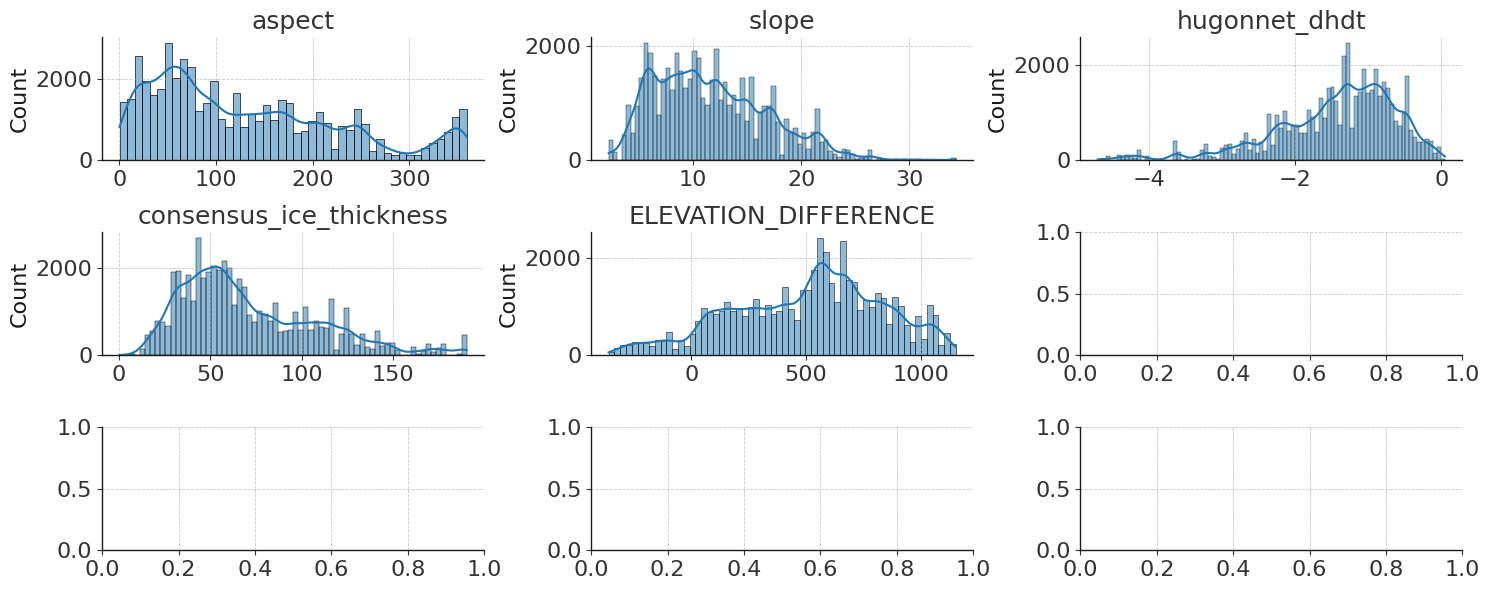

In [9]:
# Plot the distribution of the topo variables:
df = dataloader_gl.data
fig, axs = plt.subplots(3, 3, figsize=(15, 6))
for i, var in enumerate(vois_topographical + ['ELEVATION_DIFFERENCE']):
    ax = axs.flatten()[i]
    sns.histplot(df[var], ax=ax, kde=True)
    ax.set_xlabel('')
    ax.set_title(var)
plt.tight_layout()

### A.3. Train-test set split:
##### A.3.1. Spatial Cross-Validation

###### Uses specific glaciers as test set

In [10]:
test_glaciers = [
    'GOLDBERG K.', 'HALLSTAETTER G.', 'HINTEREIS F.', 'JAMTAL F.',
    'KESSELWAND F.', 'KLEINFLEISS K.', 'OE. WURTEN K.', 'VENEDIGER K.',
    'VERNAGT F.', 'ZETTALUNITZ/MULLWITZ K.'
]

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers
train_glaciers = [i for i in existing_glaciers if i not in test_glaciers]
data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))




Size of test data: 21454
Size of train data: 29379
Percentage of test size: 73.02%
Train glaciers: (14) ['CARESER' 'MALAVALLE (VEDR. DI) / UEBELTALF.'
 'PENDENTE (VEDR.) / HANGENDERF.' 'RIES OCC. (VEDR. DI) / RIESERF. WESTL.'
 'GRAND ETRET' 'CIARDONEY' 'FONTANA BIANCA / WEISSBRUNNF.'
 'LUNGA (VEDRETTA) / LANGENF.' 'CAMPO SETT.' 'LUPO' 'SURETTA MERIDIONALE'
 'CARESER OCCIDENTALE' 'CARESER ORIENTALE' 'CARESER CENTRALE']
Test glaciers: (10) ['GOLDBERG K.' 'HINTEREIS F.' 'JAMTAL F.' 'KESSELWAND F.' 'KLEINFLEISS K.'
 'OE. WURTEN K.' 'VERNAGT F.' 'HALLSTAETTER G.' 'VENEDIGER K.'
 'ZETTALUNITZ/MULLWITZ K.']


##### A.3.2. Temporal Cross-Validation

###### Uses the last X years as test set

In [ ]:
test_years_count = 10

all_years = sorted(dataloader_gl.data['YEAR'].unique())

# Use the most recent years as test data
train_years = all_years[:-test_years_count]
test_years = all_years[-test_years_count:]

# Statistics prints
print('Size of test data:', len(test_years))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_years)]
print('Size of train data:', len(train_years))
if len(train_years) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(test_years) / len(train_years)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(
                                dataloader_gl,
                                test_split_on='YEAR',
                                test_splits=test_years,
                                random_state=cfg.seed)



print('Train year: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test years: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))


##### A.3.3. Train-Test set plots

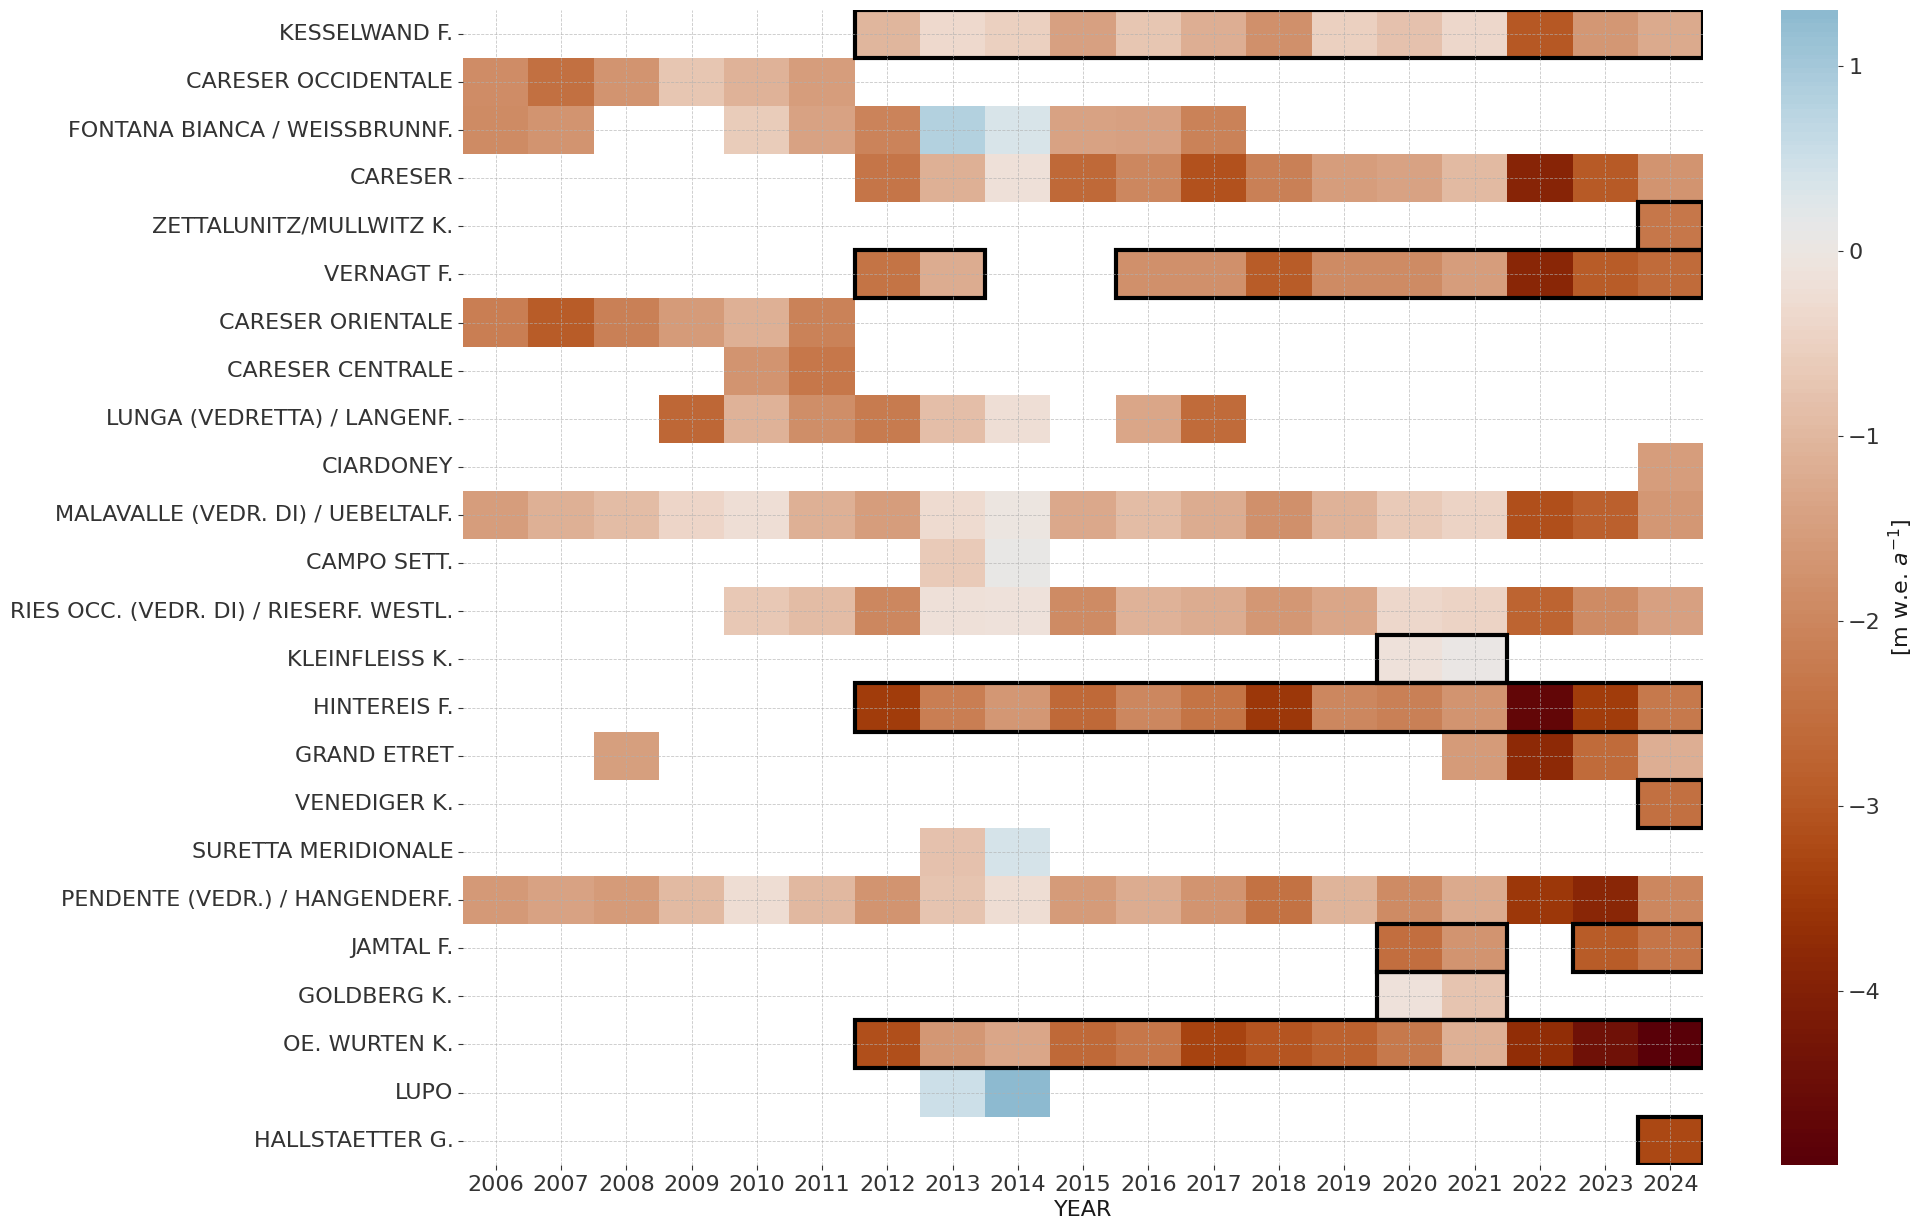

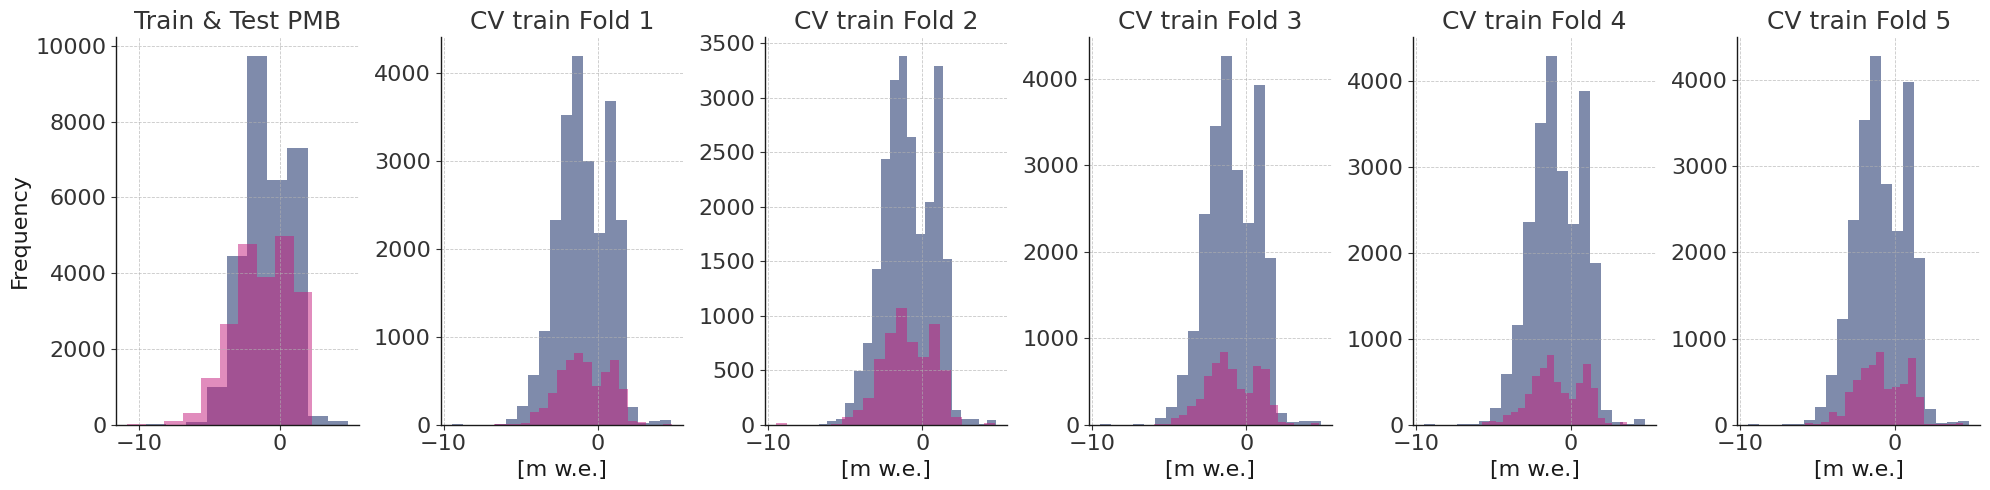

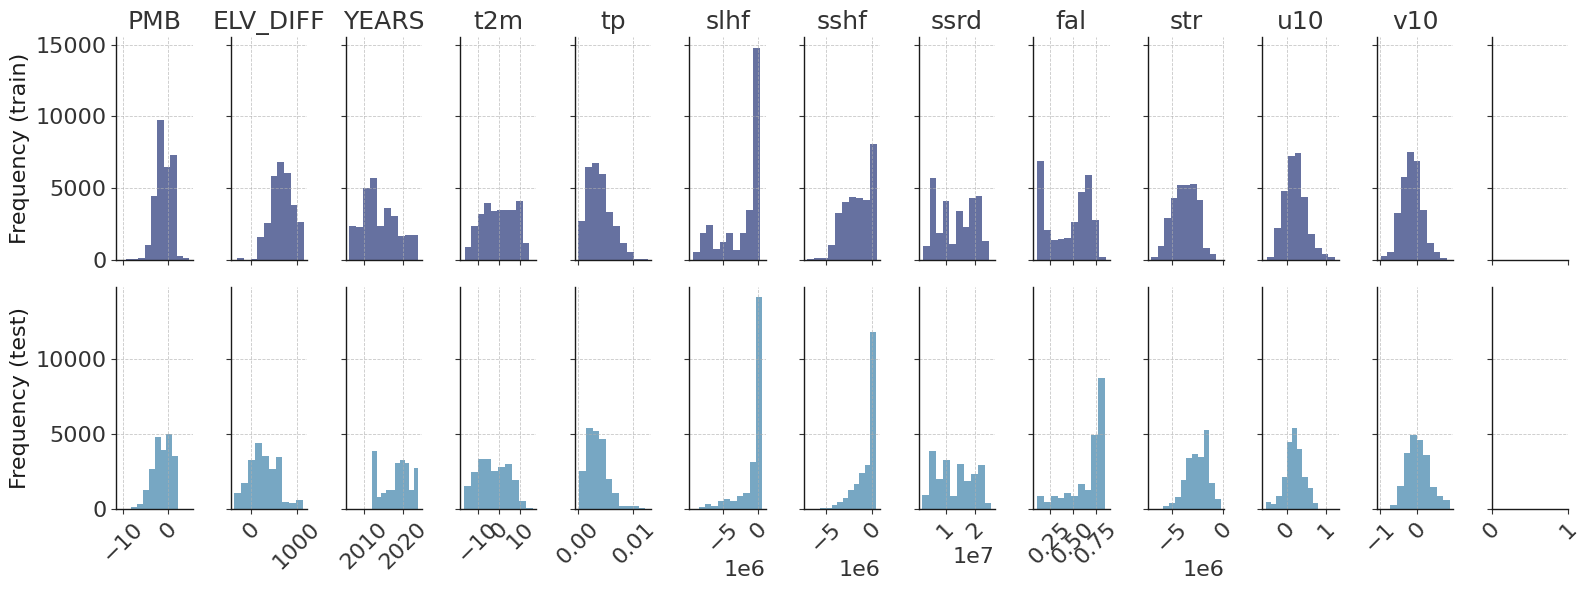

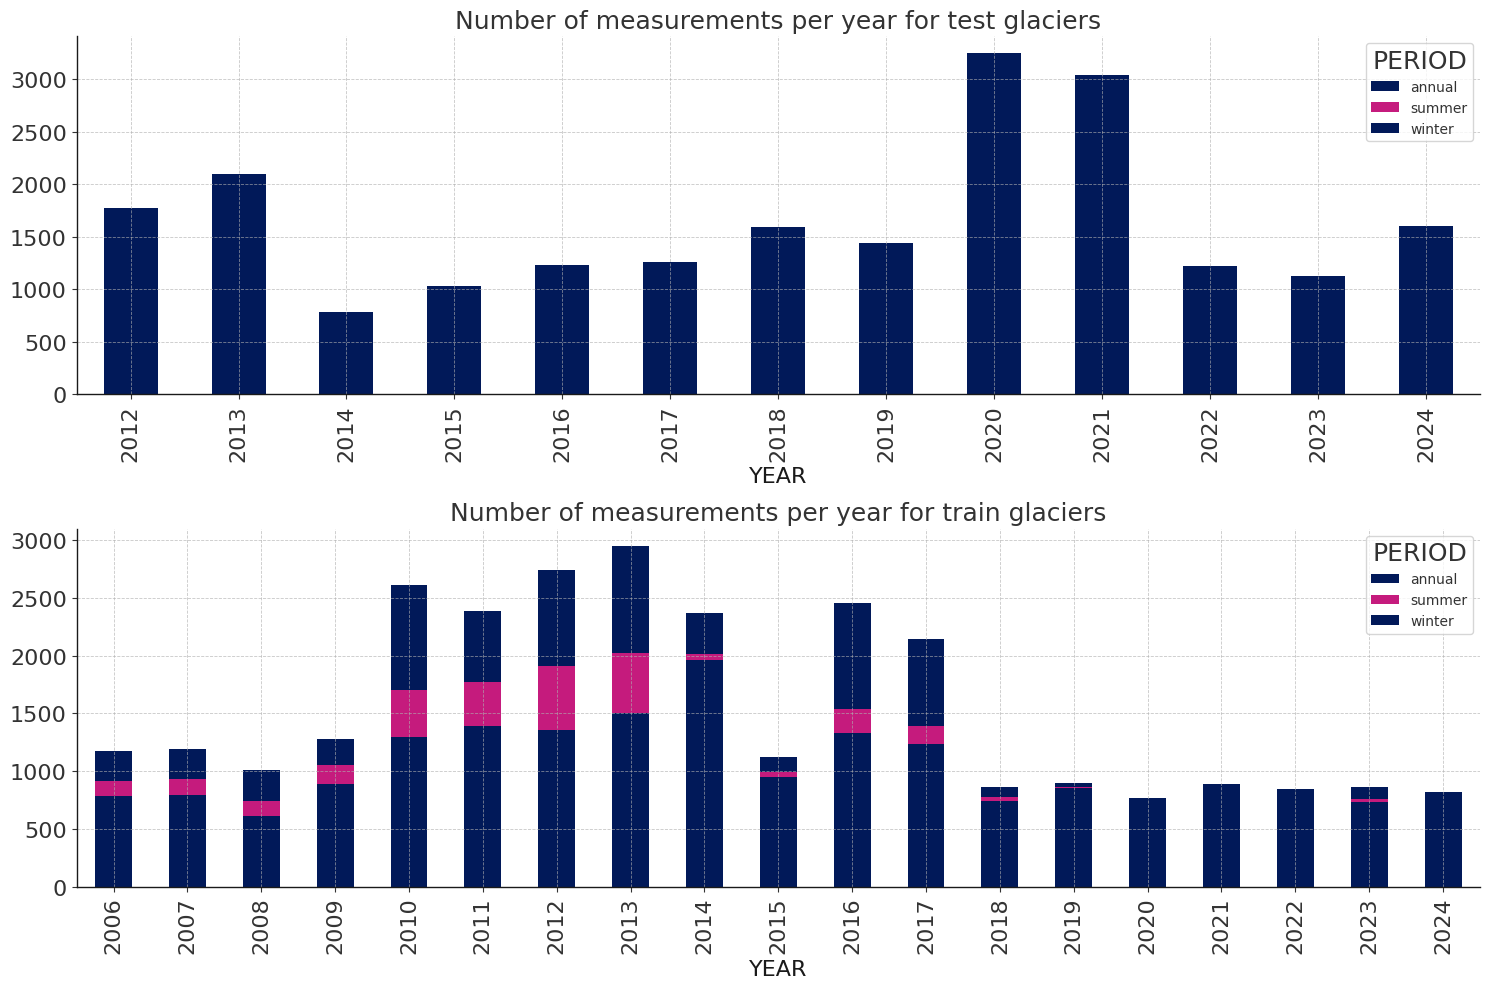

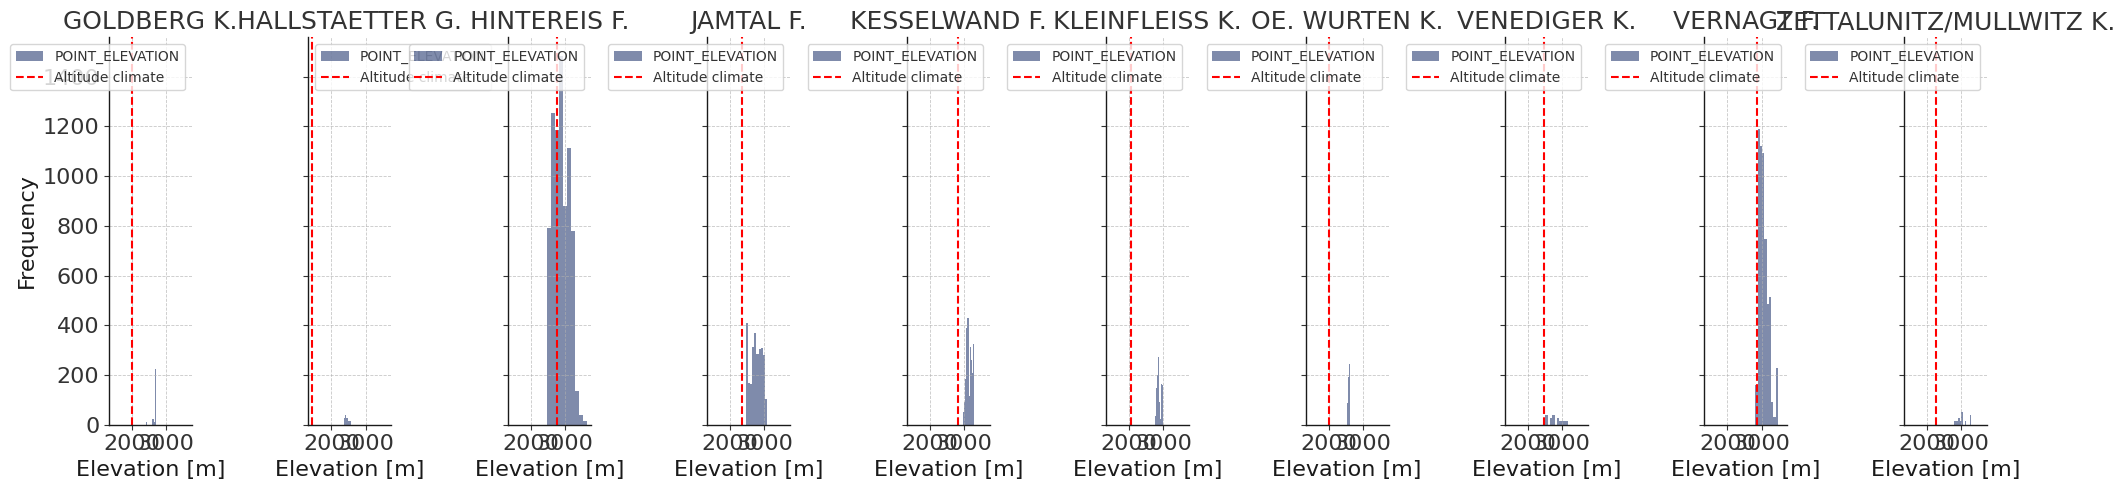

In [11]:
plotHeatmap(dataloader_gl.data, test_glaciers, period='annual')
#plotHeatmap(dataloader_gl.data, test_glaciers, period='winter')
#plotHeatmap(dataloader_gl.data, test_glaciers, period='summer')
visualiseSplits(test_set['y'], train_set['y'], splits)
visualiseInputs(train_set, test_set, vois_climate)

# Number of measurements per year:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
test_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[0])
ax[0].set_title('Number of measurements per year for test glaciers')

# Number of measurements per year:
train_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[1])
ax[1].set_title('Number of measurements per year for train glaciers')
plt.tight_layout()

f, ax = plt.subplots(1,
                     len(test_glaciers),
                     figsize=(20, 5),
                     sharey='row',
                     sharex='row')

for i, test_gl in enumerate(test_glaciers):
    test_df_gl = test_set['df_X'][test_set['df_X'].GLACIER == test_gl]
    test_df_gl.POINT_ELEVATION.plot.hist(color=color_dark_blue,
                                         alpha=0.5,
                                         density=False,
                                         ax=ax[i])
    # add vertical line for altitude climate
    alt_climate = test_df_gl.ALTITUDE_CLIMATE.mean()
    ax[i].axvline(x=alt_climate,
                  color='red',
                  linestyle='--',
                  label='Altitude climate')
    ax[i].set_xlabel('Elevation [m]')
    ax[i].legend()
    ax[i].set_title(test_gl)
plt.tight_layout()

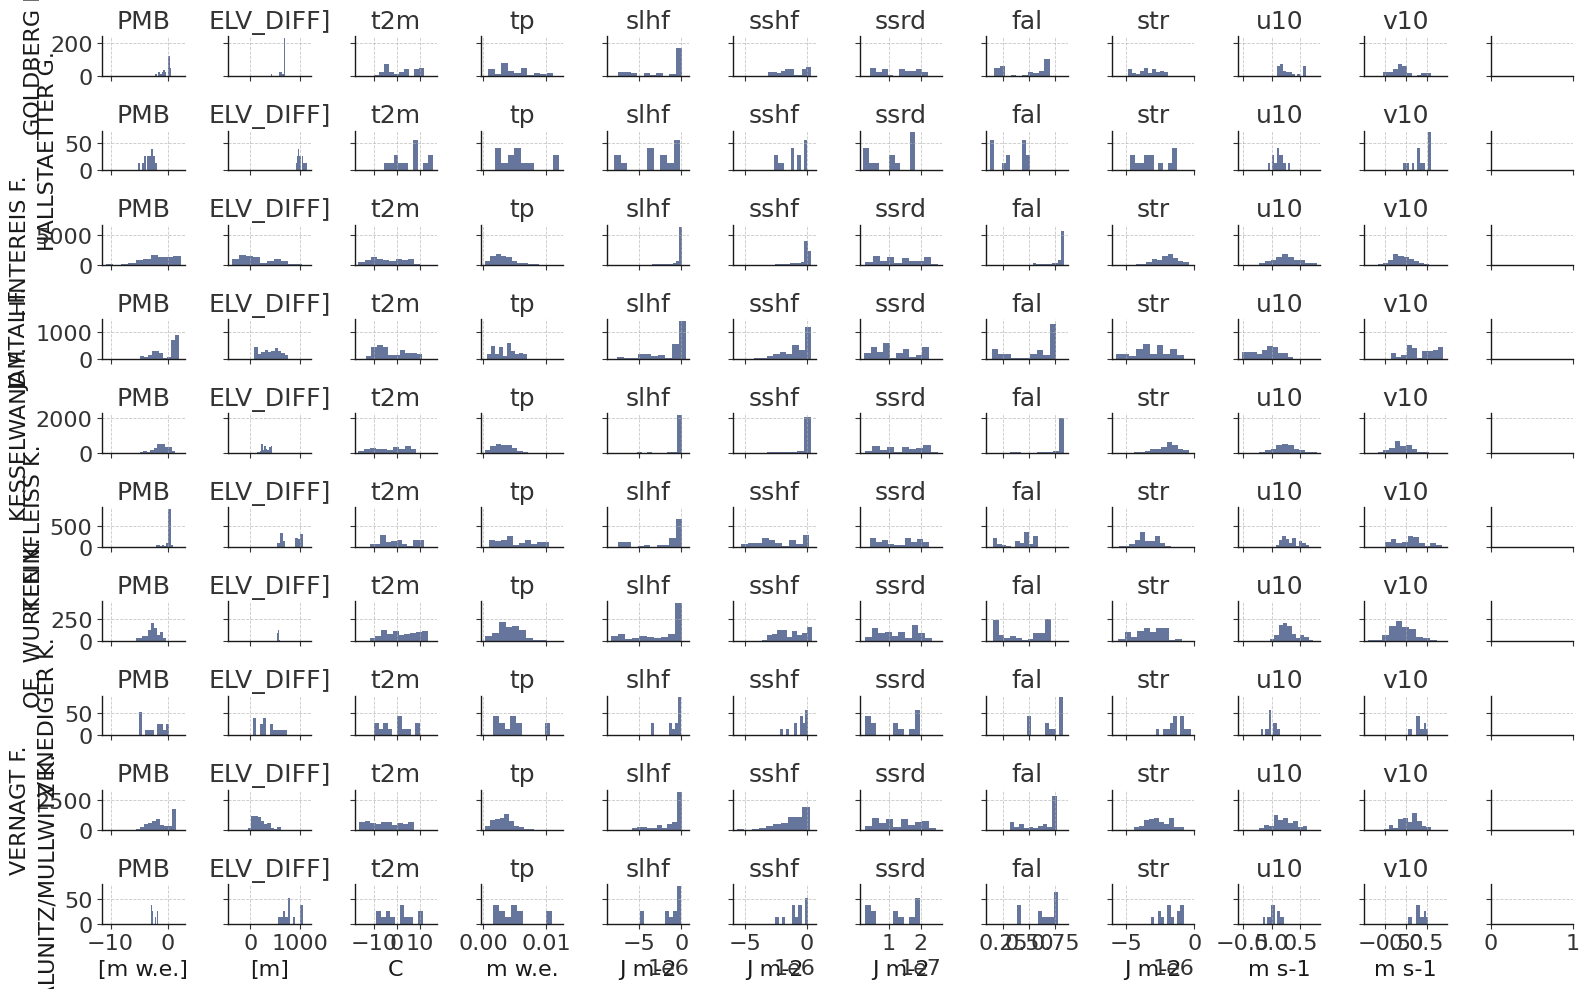

In [12]:
# plot distributions of test glaciers:
f, ax = plt.subplots(len(test_glaciers),
                     len(vois_climate) + 3,
                     figsize=(16, 10),
                     sharey='row',
                     sharex='col')

for i, test_gl in enumerate(test_glaciers):
    test_df_gl = test_set['df_X'][test_set['df_X'].GLACIER == test_gl]
    test_df_gl['POINT_BALANCE'].plot.hist(ax=ax[i, 0],
                                          color=color_dark_blue,
                                          alpha=0.6,
                                          density=False)
    ax[i, 0].set_title('PMB')
    ax[i, 0].set_ylabel(test_gl)
    ax[i, 0].set_xlabel('[m w.e.]')
    test_df_gl['ELEVATION_DIFFERENCE'].plot.hist(ax=ax[i, 1],
                                                 color=color_dark_blue,
                                                 alpha=0.6,
                                                 density=False)
    ax[i, 1].set_title('ELV_DIFF]')
    ax[i, 1].set_xlabel('[m]')

    for j, voi_clim in enumerate(vois_climate):
        ax[i, 2 + j].set_title(voi_clim)
        test_df_gl[voi_clim].plot.hist(ax=ax[i, 2 + j],
                                       color=color_dark_blue,
                                       alpha=0.6,
                                       density=False)
        ax[i, 2 + j].set_xlabel(vois_units[voi_clim])

plt.tight_layout()

#### A.4. XGBoost:

In [13]:
# Grid search
# For each of the XGBoost parameter, define the grid range
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators':
    [50, 100, 200, 300, 400, 500, 600,
     700],  # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
}

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'gpu_hist'
param_init["random_state"] = cfg.seed
param_init["n_jobs"] = 1

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
]

###### Grid search:

In [15]:
%%time
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

RUN = True
if RUN:
    # Create a CustomXGBoostRegressor instance
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg, **param_init)
    custom_xgboost.randomsearch(
        parameters=param_grid,
        n_iter=45,
        splits=splits,
        features=df_X_train_subset,
        targets=train_set['y'],
    )

    # save best model
    custom_xgboost.save_model(f'IT_train_AT_test_reworked_11_06.pkl')
else:
    # read model
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg)
    custom_xgboost.load_model(
        f'IT_train_AT_test_reworked_05_06.pkl')

# Get best parameters and estimator
best_params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)

# Calculate scores
score = best_estimator_cpu.score(test_set['df_X'][all_columns],
                                 test_set['y'])  # negative
print('Overall score:', np.abs(score))

Shape of training dataset: (29379, 25)
Shape of testing dataset: (21454, 25)
Running with features: ['ELEVATION_DIFFERENCE', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness']
Fitting 5 folds for each of 45 candidates, totalling 225 fits


/home/mburlet/anaconda3/envs/MassBalanceMachine/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:06:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mburlet/anaconda3/envs/MassBalanceMachine/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:06:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "cfg" } are not used.

  warnings.warn(smsg, UserWarning)
/home/mburlet/anaconda3/envs/MassBalanceMachine/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:06:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mburlet/anaco

Best parameters:
 {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.1}
Best score:
 -0.14301958937133807
Shape of the test: (21454, 14)
Overall score: 2.4417768930297137
CPU times: user 25.6 s, sys: 1.98 s, total: 27.5 s
Wall time: 7min 19s


learning_rate  max_depth  n_estimators  Validation rmse  Train rmse
Model                                                                     
1               0.10          6           500         0.143020    0.001352
2               0.10          6           400         0.144218    0.001947
3               0.01          8           500         0.148207    0.010019
4               0.10          6           200         0.151707    0.006795
5               0.10          4           500         0.152456    0.014496
6               0.10          5           700         0.152720    0.002341
7               0.10          7           700         0.153197    0.000649
8               0.10          7           400         0.153553    0.000871
9               0.10          5           400         0.158457    0.006144
10              0.10          8           700         0.168673    0.000633

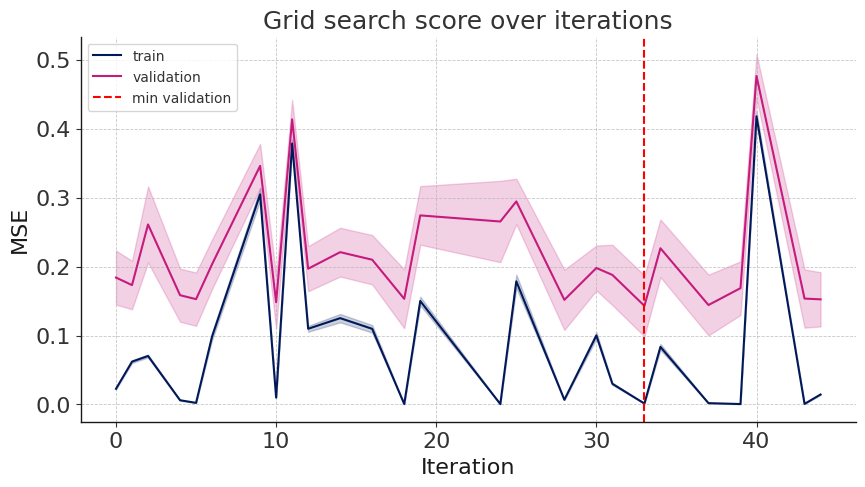

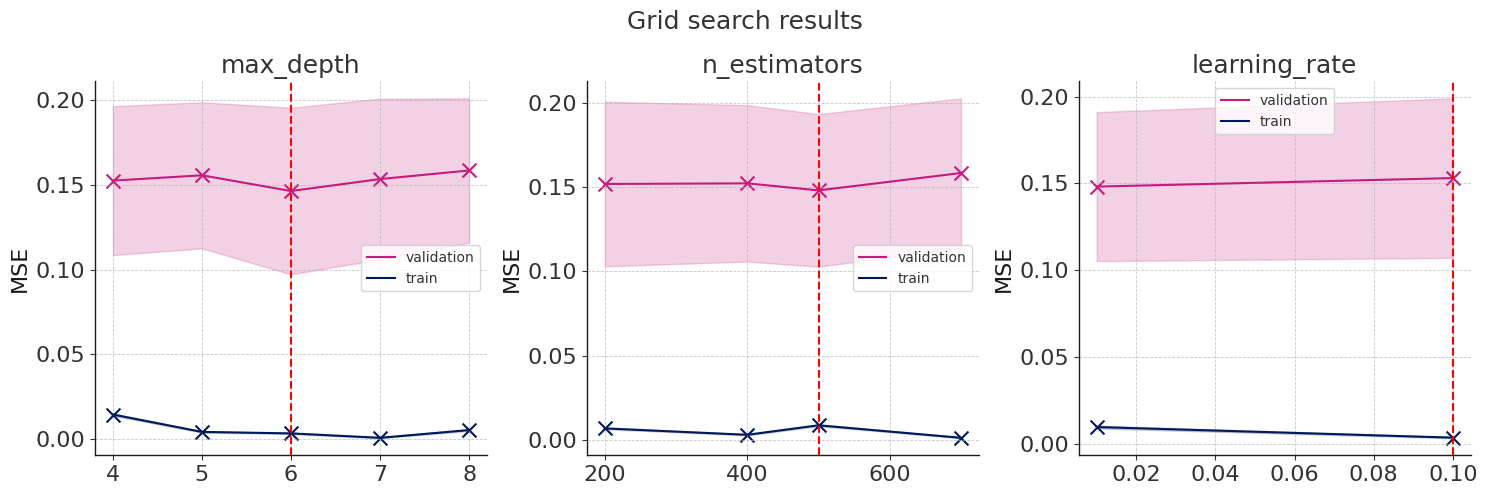

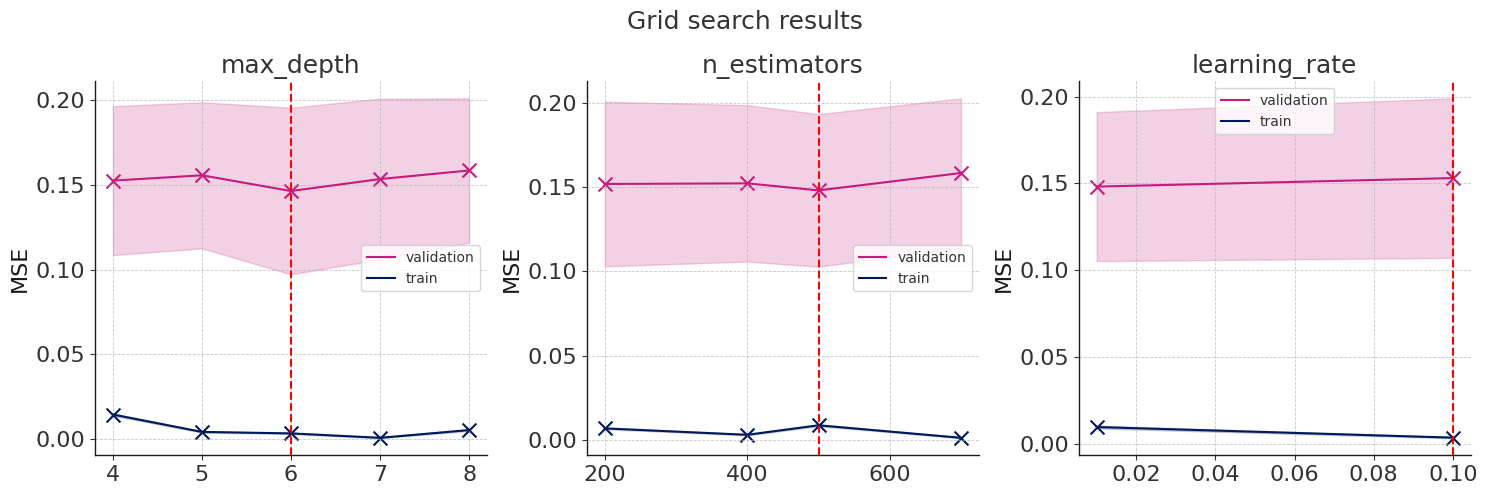

In [16]:
plotGridSearchScore(cv_results_=custom_xgboost.param_search.cv_results_,
                    lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss,
                     N=10)

print_top_n_models(custom_xgboost.param_search.cv_results_)

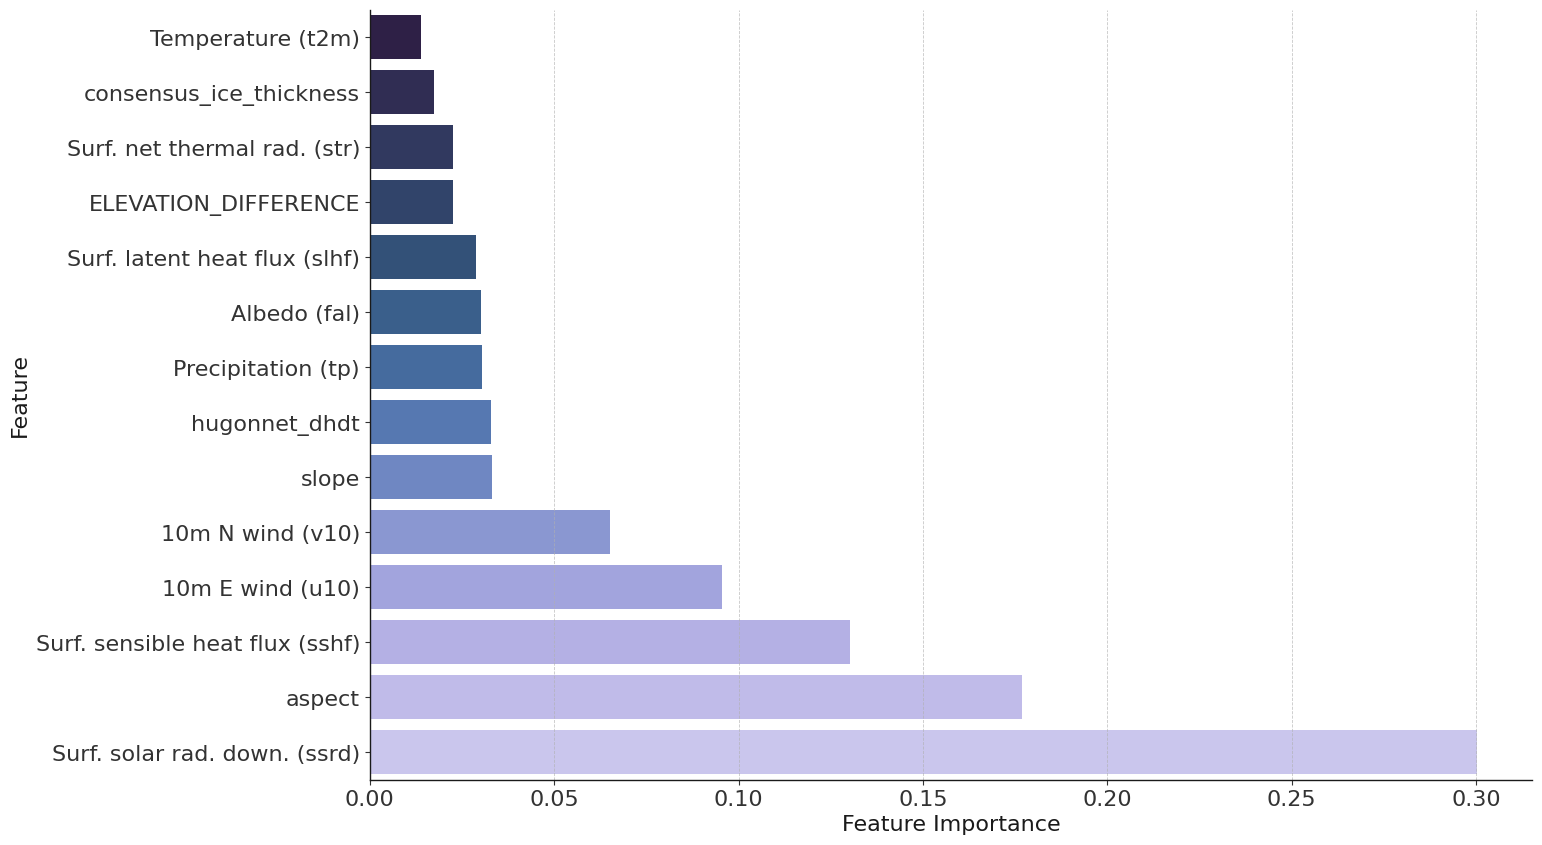

In [17]:
FIPlot(best_estimator, feature_columns, vois_climate)

###### Predictions of best parameters:

Shape of the test: (21454, 14)


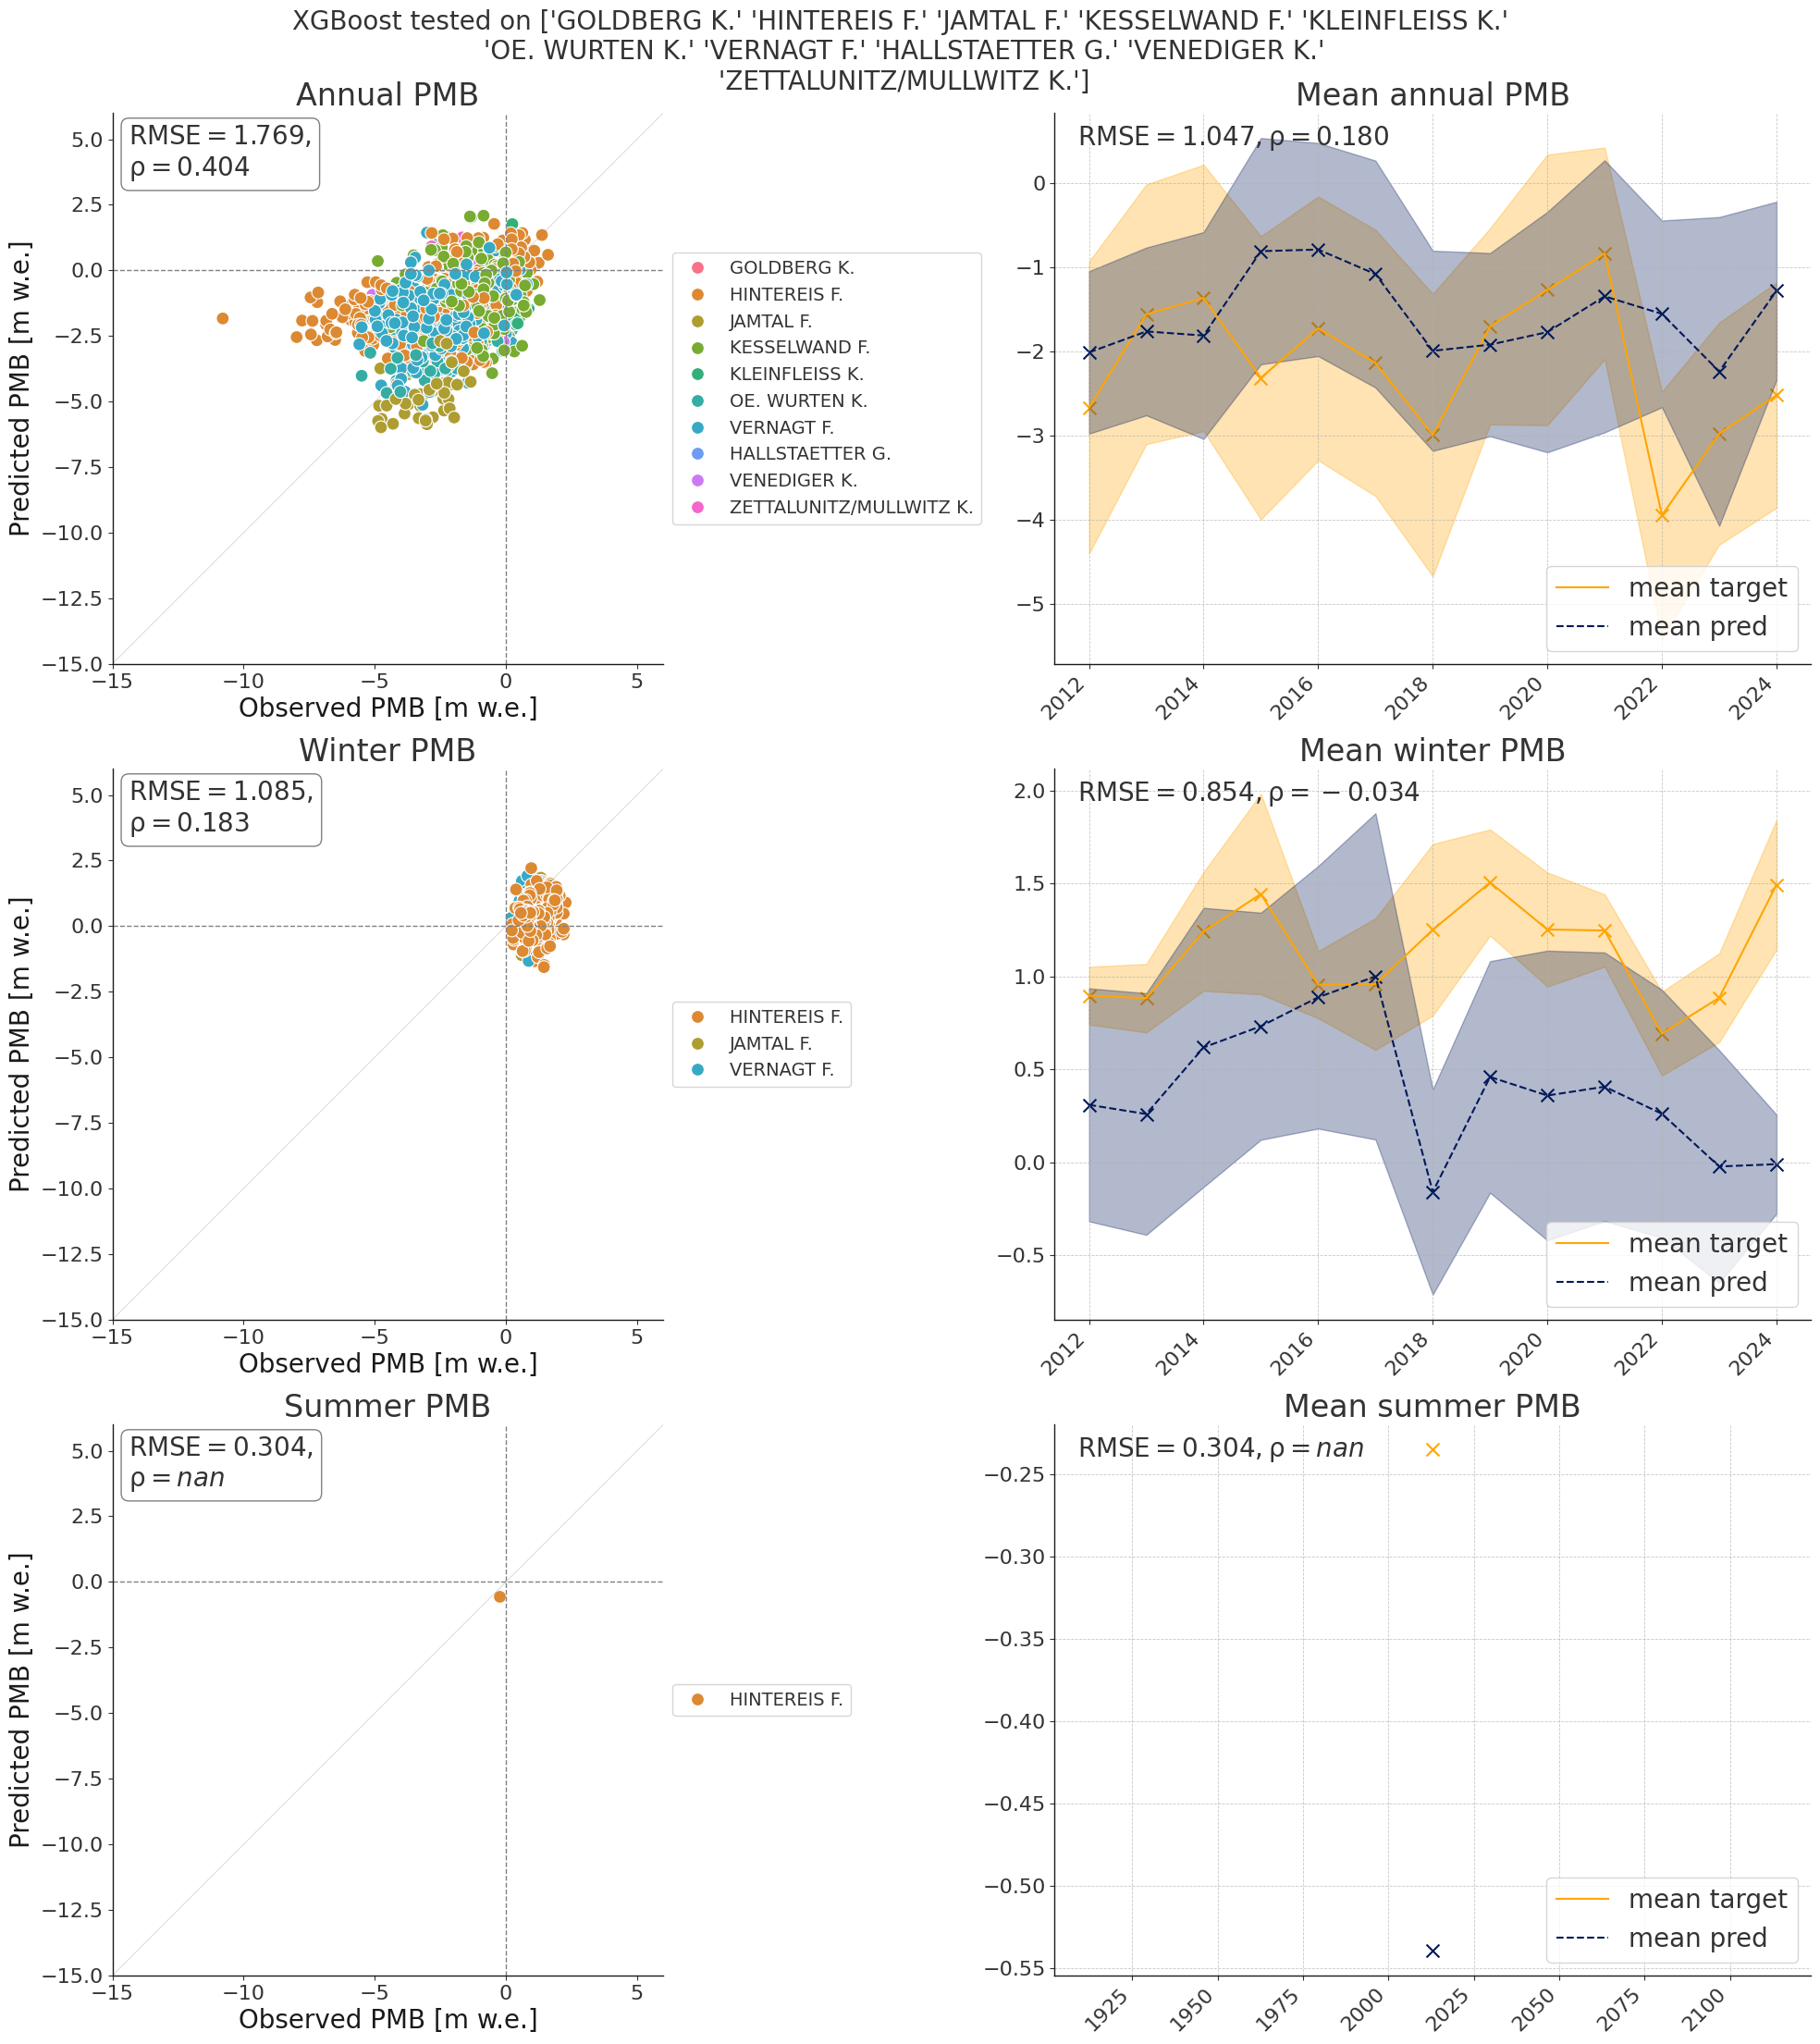

In [18]:
# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)
grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu, include_summer=True)
plt.suptitle(f'XGBoost tested on {test_set["splits_vals"]}', fontsize=20)
plt.tight_layout()

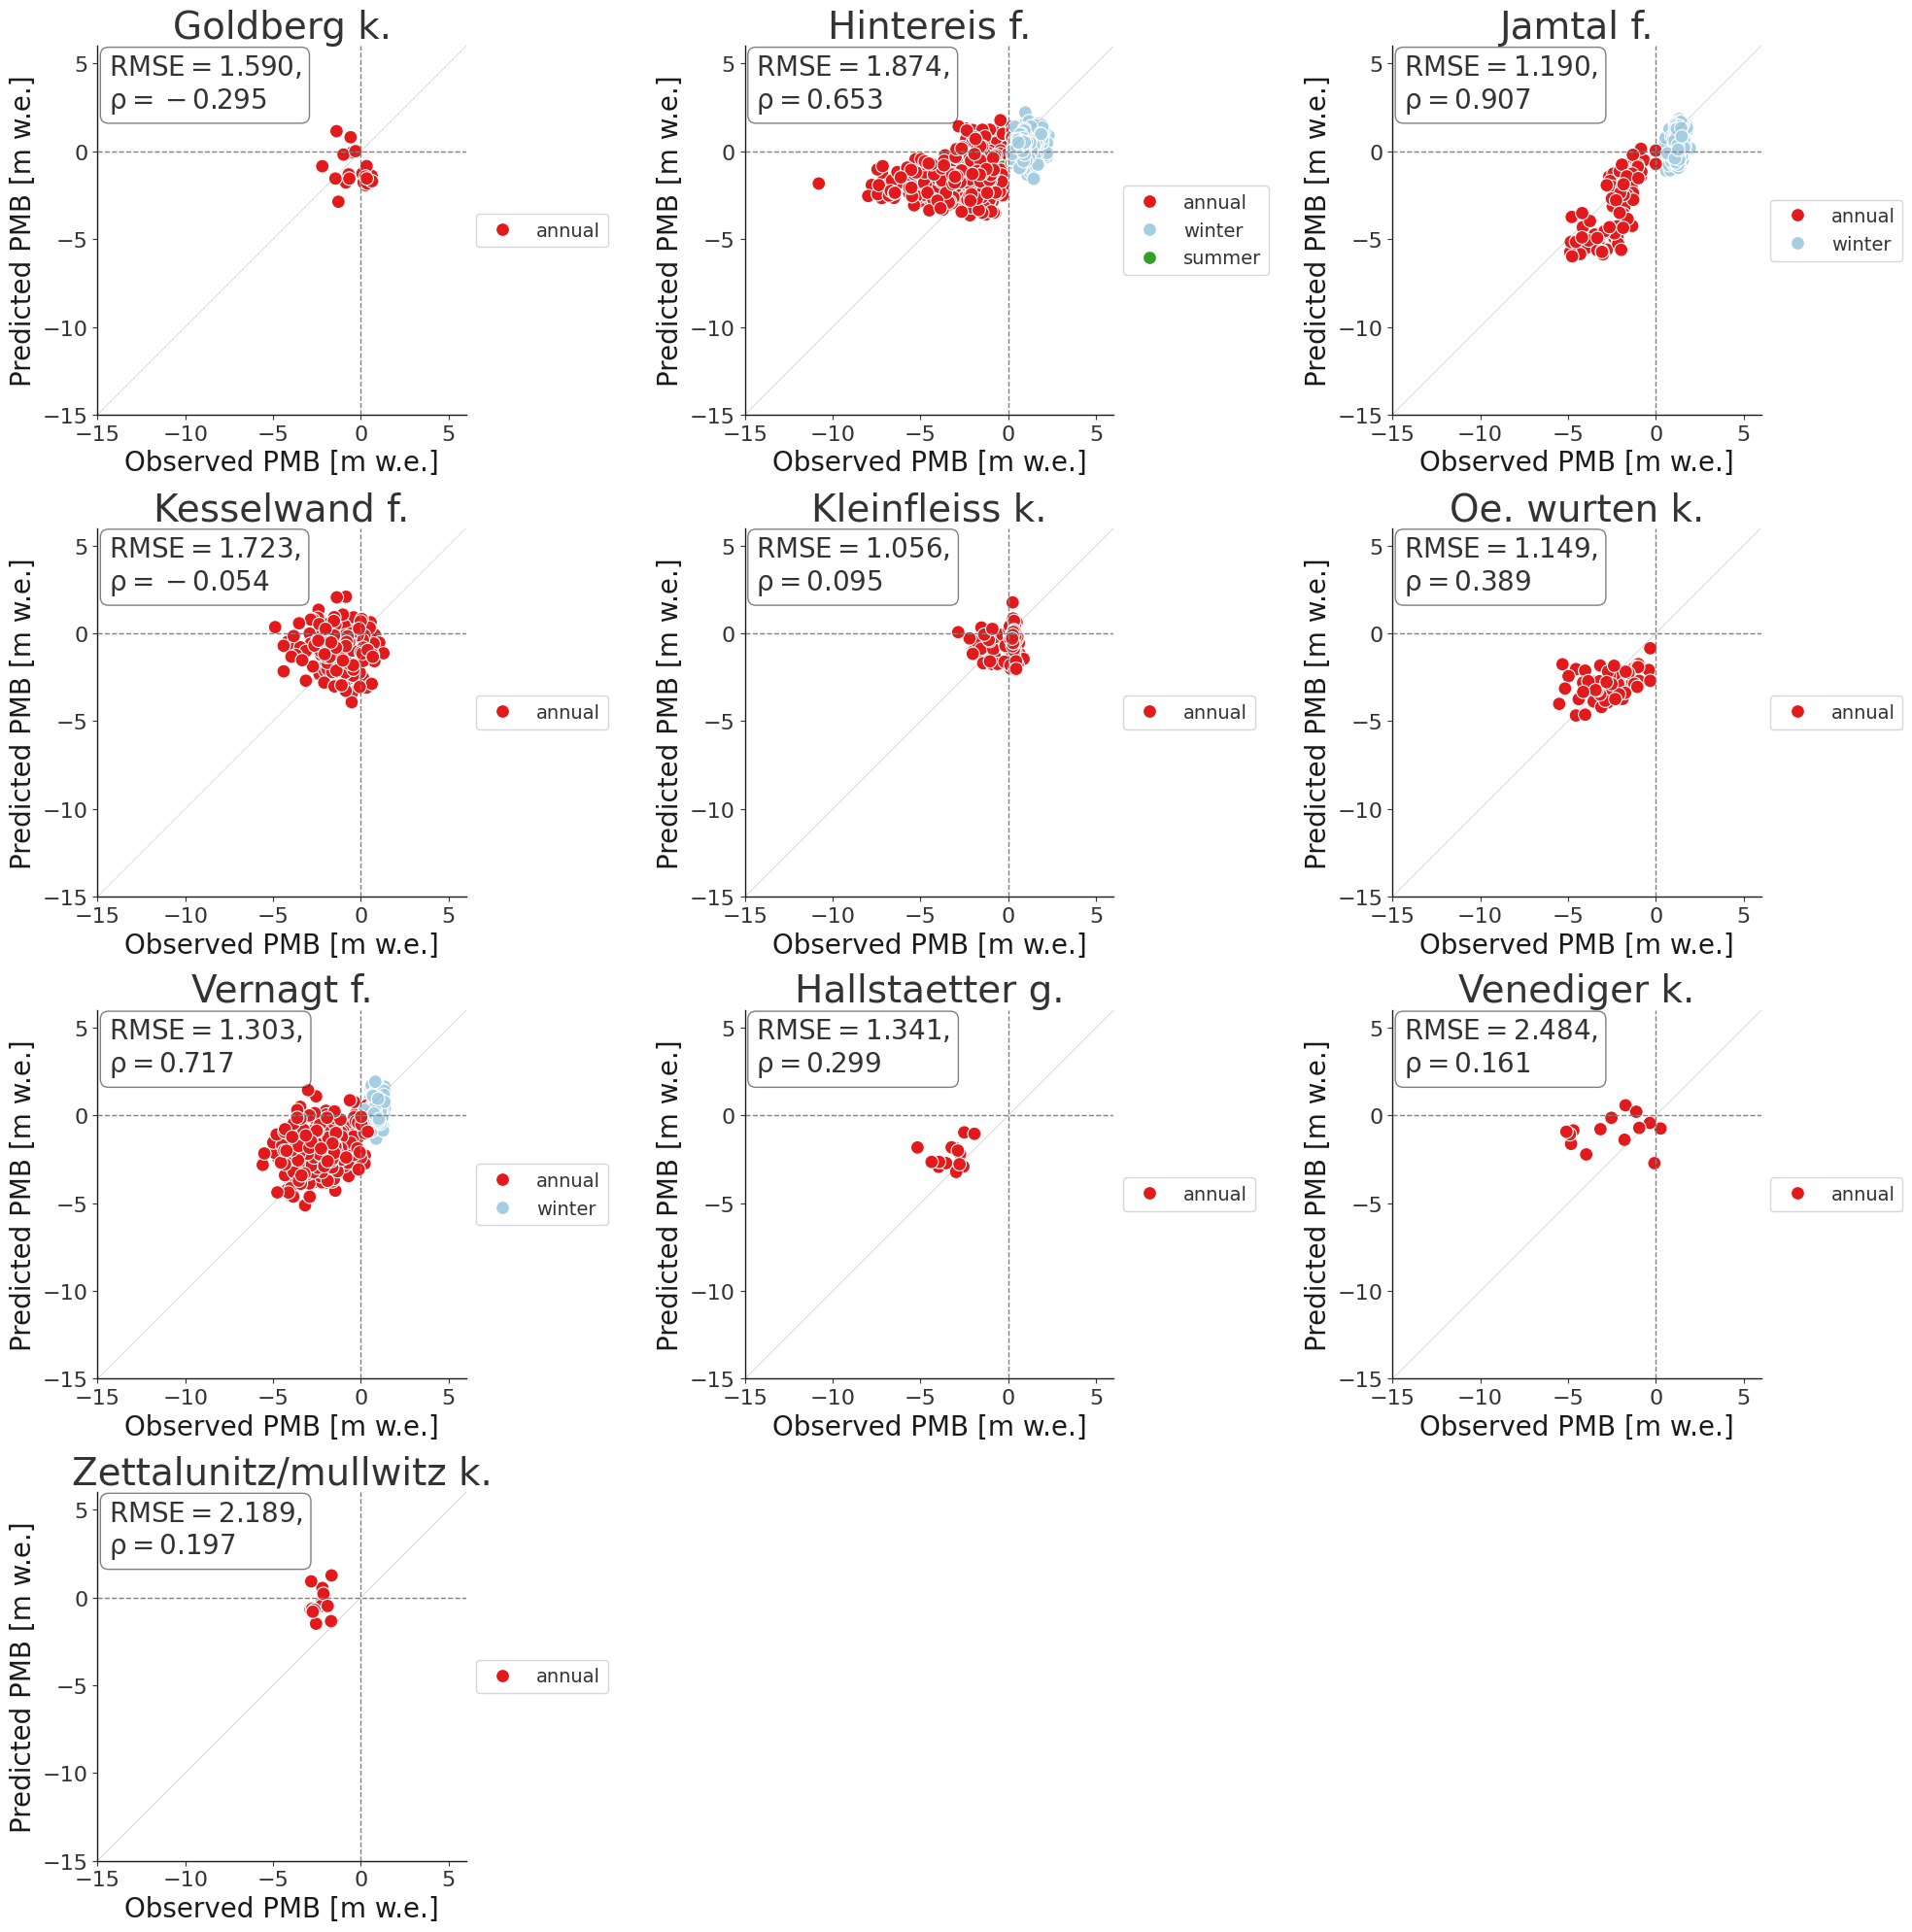

In [19]:
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))

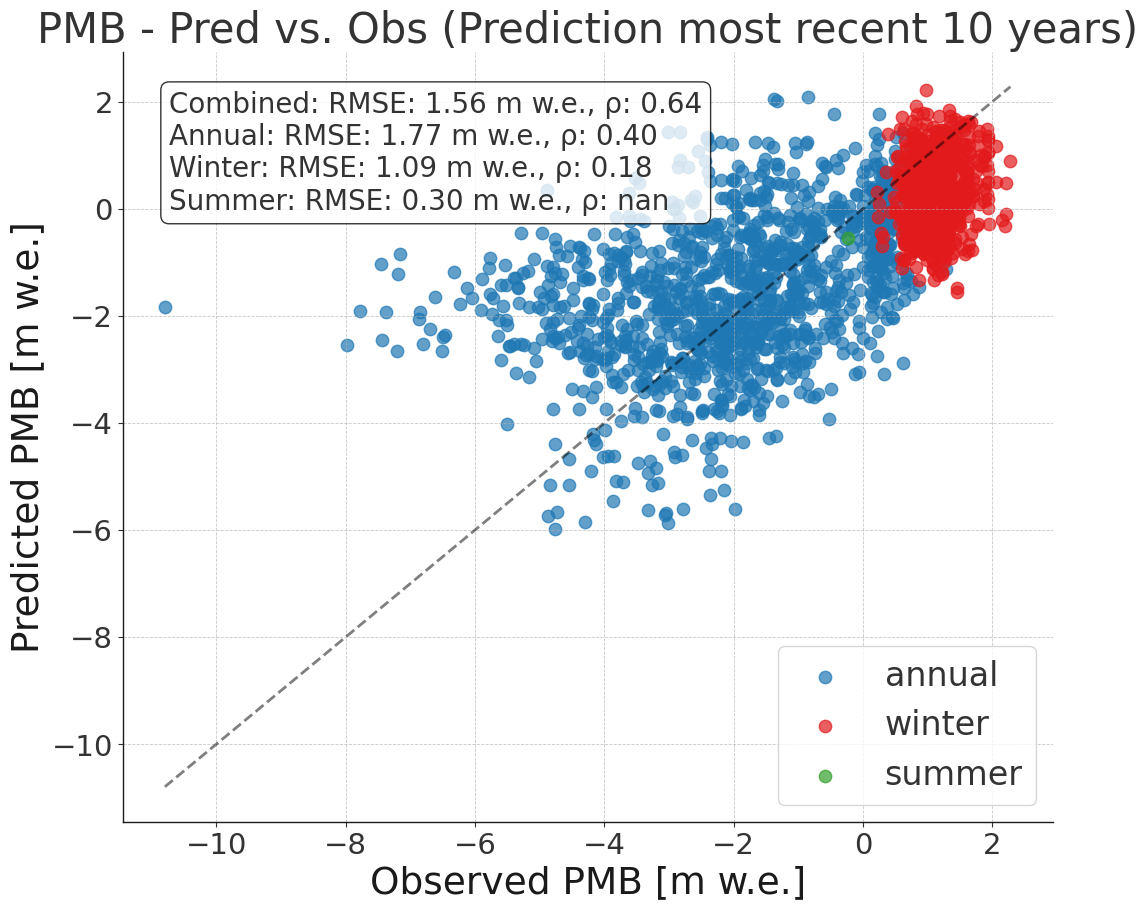

In [20]:
PlotPredictionsCombined(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu, region_name='Prediction most recent 10 years', include_summer = True)

### B.1. Train CH Test FR

###### Load CH galciers and merge with IT_AT

In [22]:
data_CH = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/CH_wgms_dataset_all_04_06_oggm.csv')
data_IT_AT = pd.read_csv(cfg.dataPath + path_PMB_WGMS_csv + 'IT_AT_wgms_dataset_all_oggm.csv')
data_IT_AT = data_IT_AT[data_IT_AT['PERIOD'] != 'summer']

display(data_CH.columns)

display(data_IT_AT.columns)

data_CH = data_CH.drop(['millan_v', 'aspect_sgi', 'slope_sgi', 'topo_sgi'], axis=1)

display(data_CH.columns)

# Merge CH with IT_AT
data_IT_AT_CH = pd.concat([data_IT_AT, data_CH], axis=0).reset_index(drop=True)

Index(['YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
       'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness',
       'millan_v', 'aspect_sgi', 'slope_sgi', 'topo_sgi'],
      dtype='object')

Index(['POINT_ID', 'POINT_LAT', 'POINT_LON', 'POINT_ELEVATION', 'FROM_DATE',
       'TO_DATE', 'POINT_BALANCE', 'GLACIER', 'PERIOD', 'RGIId', 'YEAR',
       'DATA_MODIFICATION', 'aspect', 'slope', 'topo', 'hugonnet_dhdt',
       'consensus_ice_thickness'],
      dtype='object')

Index(['YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
       'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness'],
      dtype='object')

In [23]:
data_IT_AT_CH_test = data_IT_AT_CH.copy()

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_WGMS_csv,
    'era5_climate_data': '/home/mburlet/scratch/data/DATA_MB/GLACIOCLIM/ERA5Land/raw/era5_monthly_averaged_data_Alps.nc', # cfg.dataPath + path_ERA5_raw
    'geopotential_data': '/home/mburlet/scratch/data/DATA_MB/GLACIOCLIM/ERA5Land/raw/era5_geopotential_pressure_Alps.nc'  # cfg.dataPath + path_ERA5_raw
}

RUN = True
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_IT_AT_CH_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file= 'CH_IT_AT_wgms_dataset_monthly_full.csv')
data_monthly_CH_IT_AT = dataloader_gl.data

display(data_monthly_CH_IT_AT.head(2))

2025-06-11 12:19:34,460 - INFO - Number of annual and seasonal samples: 37778
2025-06-11 12:19:34,464 - INFO - Running on 63 glaciers:
['GOLDBERG K.' 'HINTEREIS F.' 'JAMTAL F.' 'KESSELWAND F.' 'KLEINFLEISS K.'
 'OE. WURTEN K.' 'VERNAGT F.' 'CARESER'
 'MALAVALLE (VEDR. DI) / UEBELTALF.' 'PENDENTE (VEDR.) / HANGENDERF.'
 'RIES OCC. (VEDR. DI) / RIESERF. WESTL.' 'GRAND ETRET' 'HALLSTAETTER G.'
 'VENEDIGER K.' 'ZETTALUNITZ/MULLWITZ K.' 'CIARDONEY'
 'FONTANA BIANCA / WEISSBRUNNF.' 'LUNGA (VEDRETTA) / LANGENF.'
 'CAMPO SETT.' 'LUPO' 'SURETTA MERIDIONALE' 'CARESER OCCIDENTALE'
 'CARESER ORIENTALE' 'CARESER CENTRALE' 'adler' 'albigna' 'aletsch'
 'allalin' 'basodino' 'cantun' 'chessjen' 'clariden' 'corbassiere'
 'corvatsch' 'damma' 'findelen' 'forno' 'gietro' 'gorner' 'gries'
 'hohlaub' 'joeri' 'limmern' 'morteratsch' 'murtel' 'oberaar' 'otemma'
 'pizol' 'plainemorte' 'plattalva' 'rhone' 'sanktanna' 'sardona'
 'schwarzbach' 'schwarzberg' 'sexrouge' 'silvretta' 'taelliboden' 'tiefen'
 'tortin' '

YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
0  2020  12.965073  47.041127          0.276       2005.391746   
1  2020  12.965073  47.041127          0.276       2005.391746   

   ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
0            694.608254           2700.0  RGI60-11.00289   
1            694.608254           2700.0  RGI60-11.00289   

                    POINT_ID  ID  ...  consensus_ice_thickness       t2m  \
0  GOLDBERG K._2020_43346_AT   0  ...                48.199932  4.489166   
1  GOLDBERG K._2020_43346_AT   0  ...                48.199932 -2.252045   

         tp       slhf       sshf       ssrd       fal        str       u10  \
0  0.003263 -2294156.0 -1238456.0  9166658.0  0.229964 -3531426.0  0.265247   
1  0.011189  -350702.0  -297682.0  5373324.0  0.610374 -2029100.0  0.098144   

        v10  
0  0.430276  
1  0.601274  

[2 rows x 27 columns]

In [24]:
test_glaciers = list(data_IT_AT['GLACIER'].unique())

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers
train_glaciers = list(data_CH['GLACIER'].unique())
data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))

Size of test data: 47883
Size of train data: 290682
Percentage of test size: 16.47%
Train glaciers: (39) ['adler' 'albigna' 'aletsch' 'allalin' 'basodino' 'cantun' 'chessjen'
 'clariden' 'corbassiere' 'corvatsch' 'damma' 'findelen' 'forno' 'gietro'
 'gorner' 'gries' 'hohlaub' 'joeri' 'limmern' 'morteratsch' 'murtel'
 'oberaar' 'otemma' 'pizol' 'plainemorte' 'plattalva' 'rhone' 'sanktanna'
 'sardona' 'schwarzbach' 'schwarzberg' 'sexrouge' 'silvretta'
 'taelliboden' 'tiefen' 'tortin' 'tsanfleuron' 'vorab' 'witenwasseren']
Test glaciers: (24) ['GOLDBERG K.' 'HINTEREIS F.' 'JAMTAL F.' 'KESSELWAND F.' 'KLEINFLEISS K.'
 'OE. WURTEN K.' 'VERNAGT F.' 'CARESER'
 'MALAVALLE (VEDR. DI) / UEBELTALF.' 'PENDENTE (VEDR.) / HANGENDERF.'
 'RIES OCC. (VEDR. DI) / RIESERF. WESTL.' 'GRAND ETRET' 'HALLSTAETTER G.'
 'VENEDIGER K.' 'ZETTALUNITZ/MULLWITZ K.' 'CIARDONEY'
 'FONTANA BIANCA / WEISSBRUNNF.' 'LUNGA (VEDRETTA) / LANGENF.'
 'CAMPO SETT.' 'LUPO' 'SURETTA MERIDIONALE' 'CARESER OCCIDENTALE'
 'CARESER OR

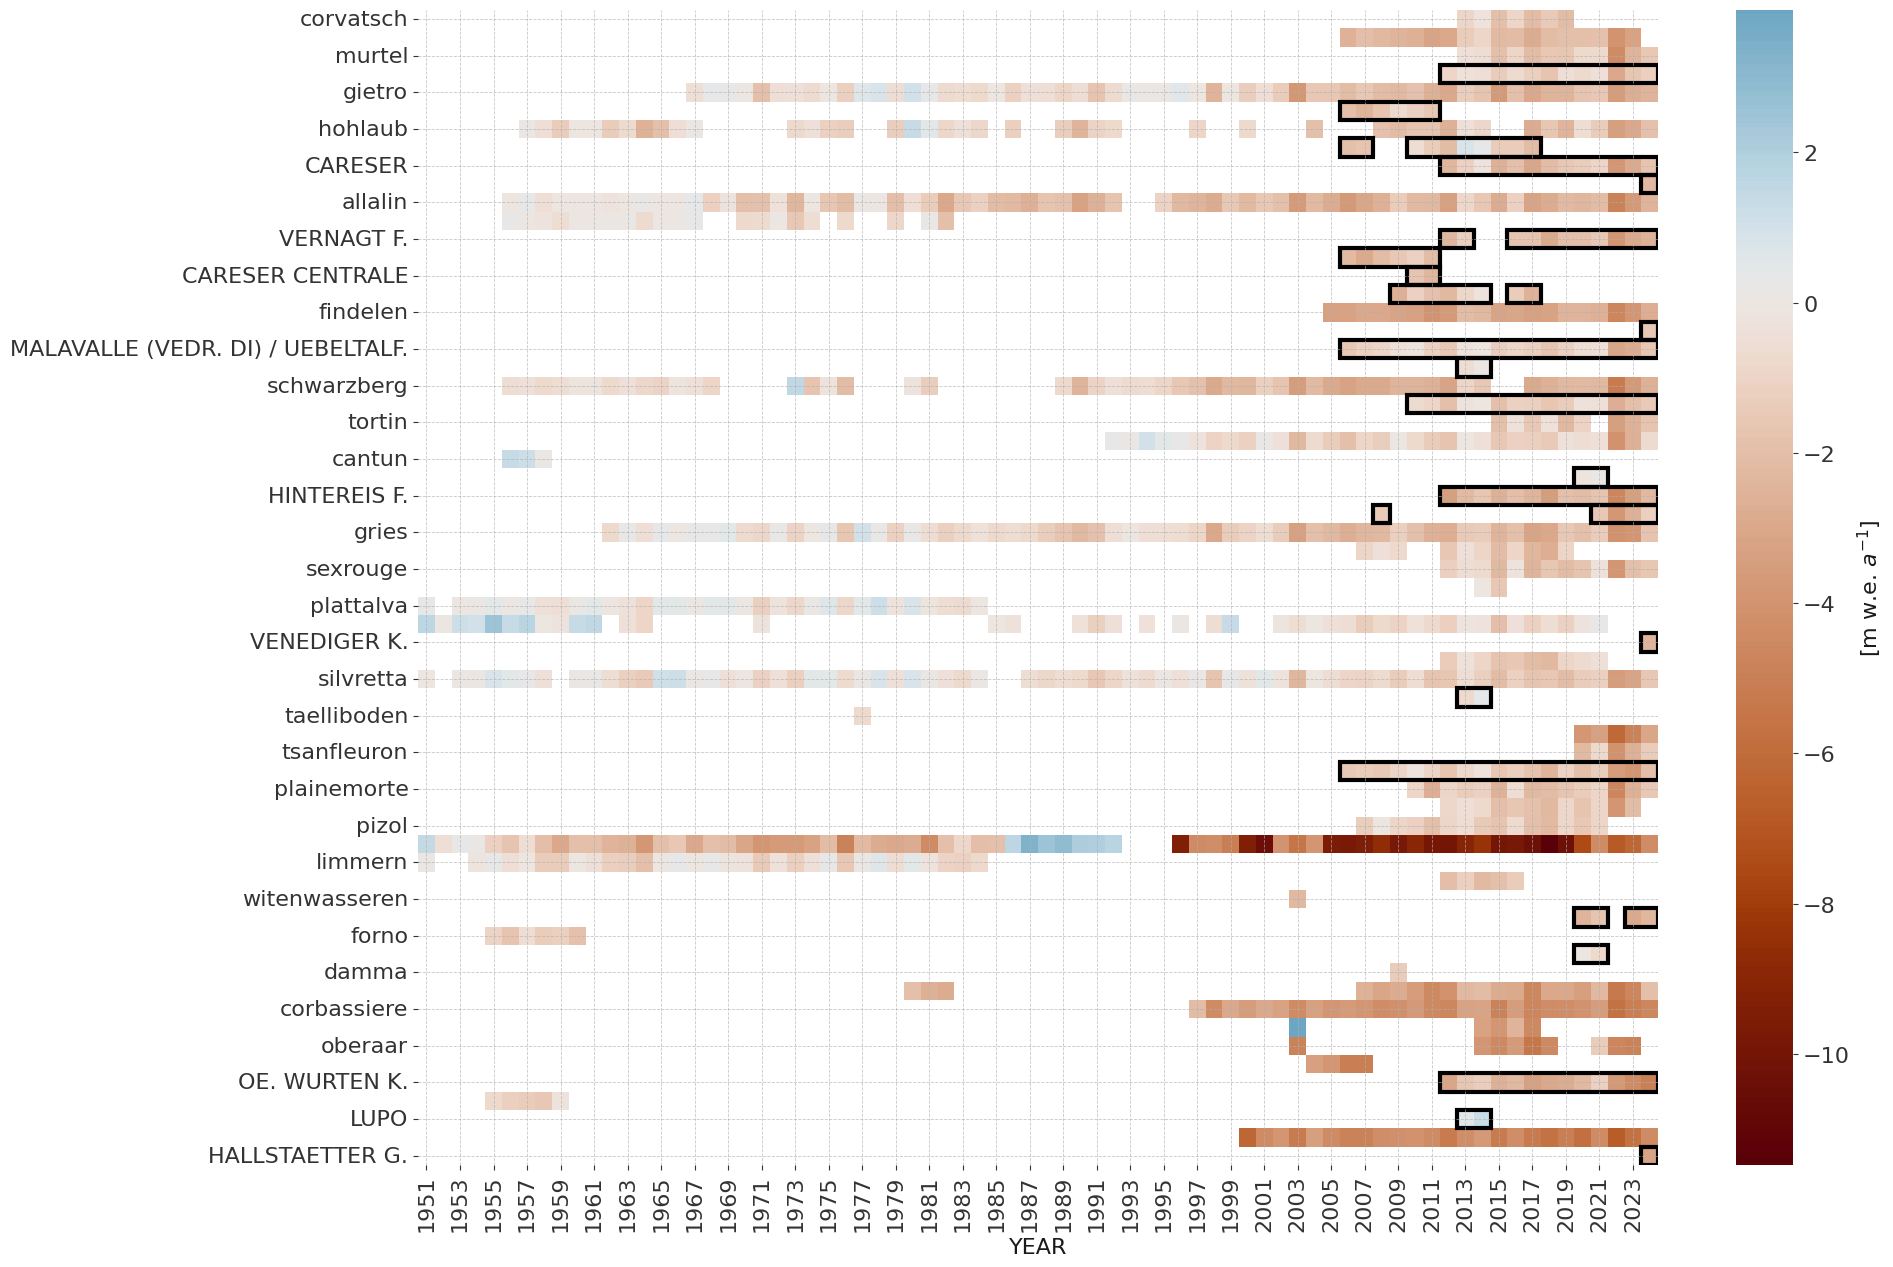

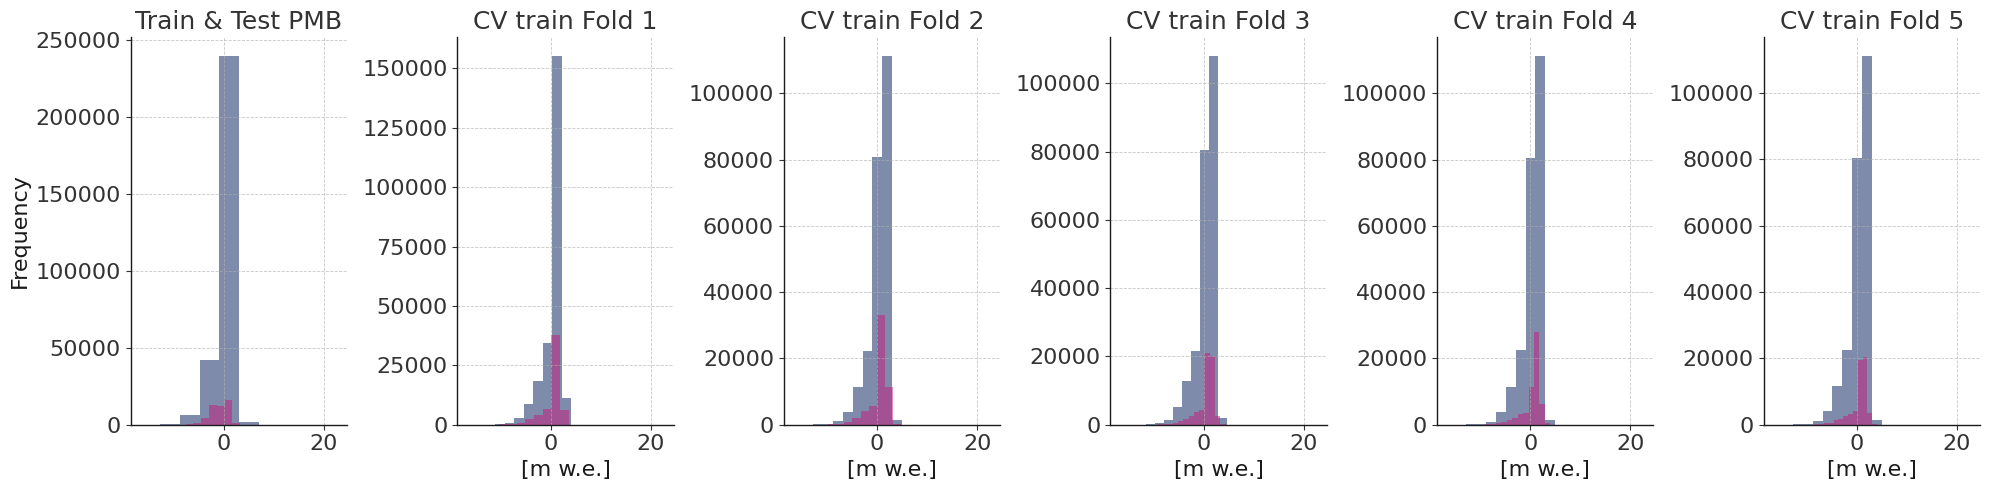

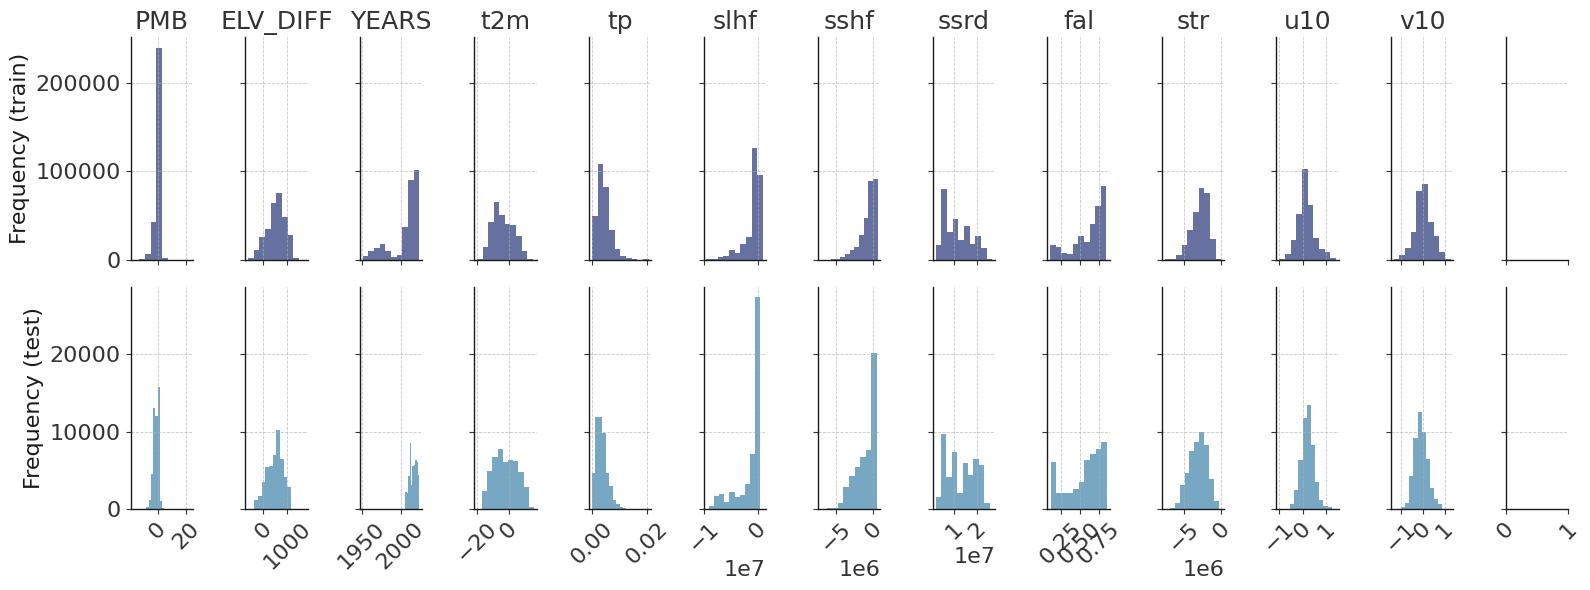

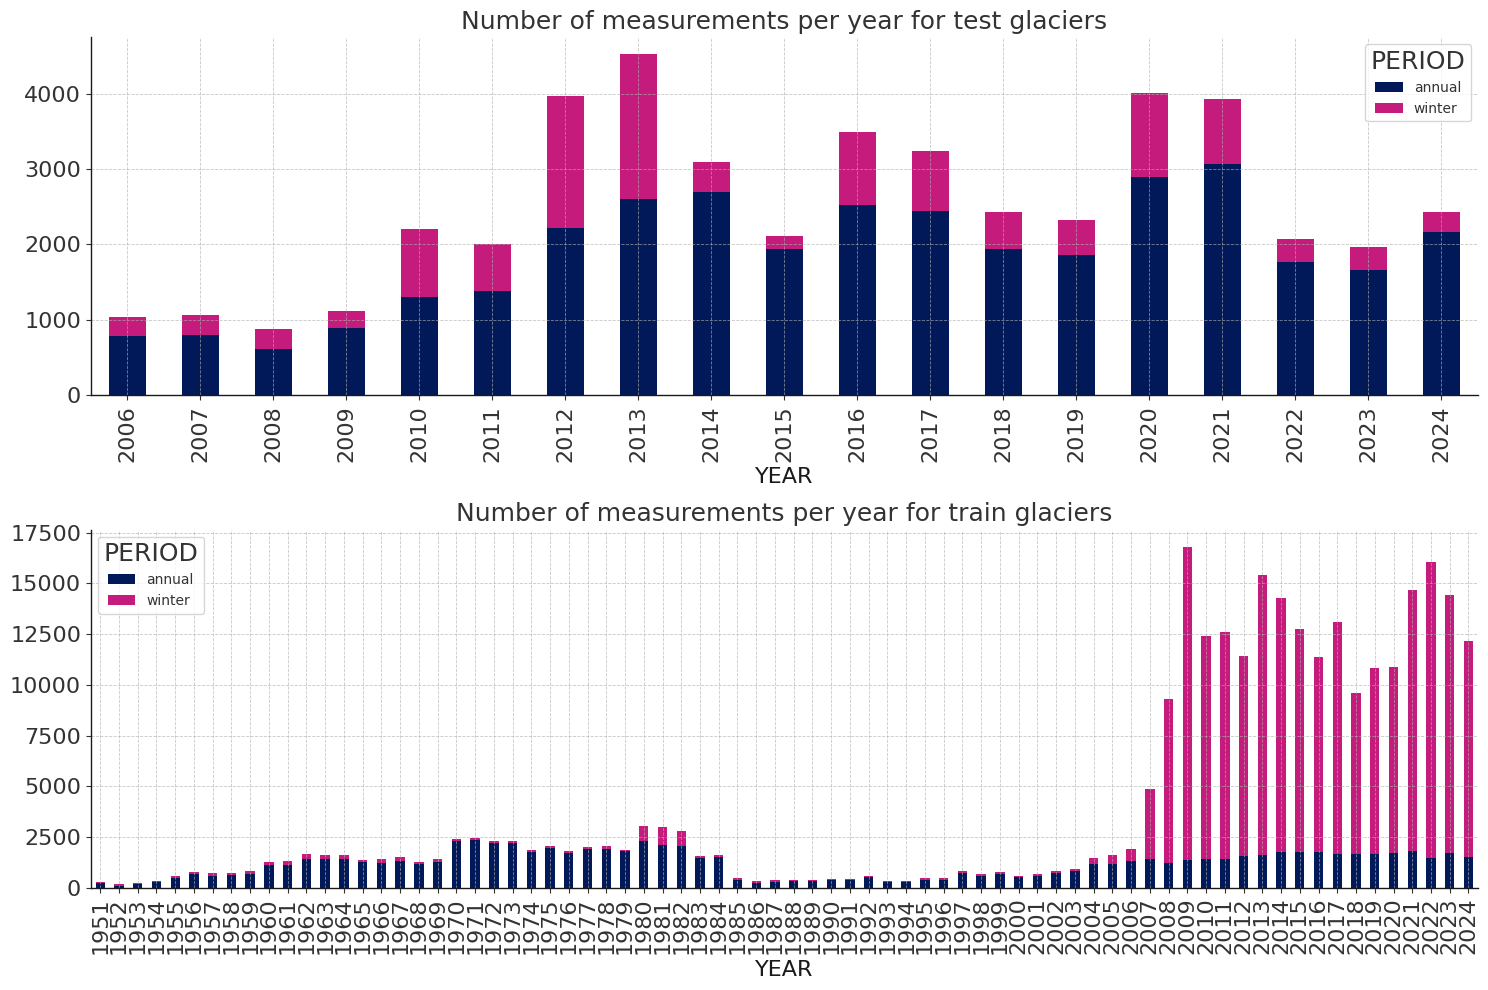

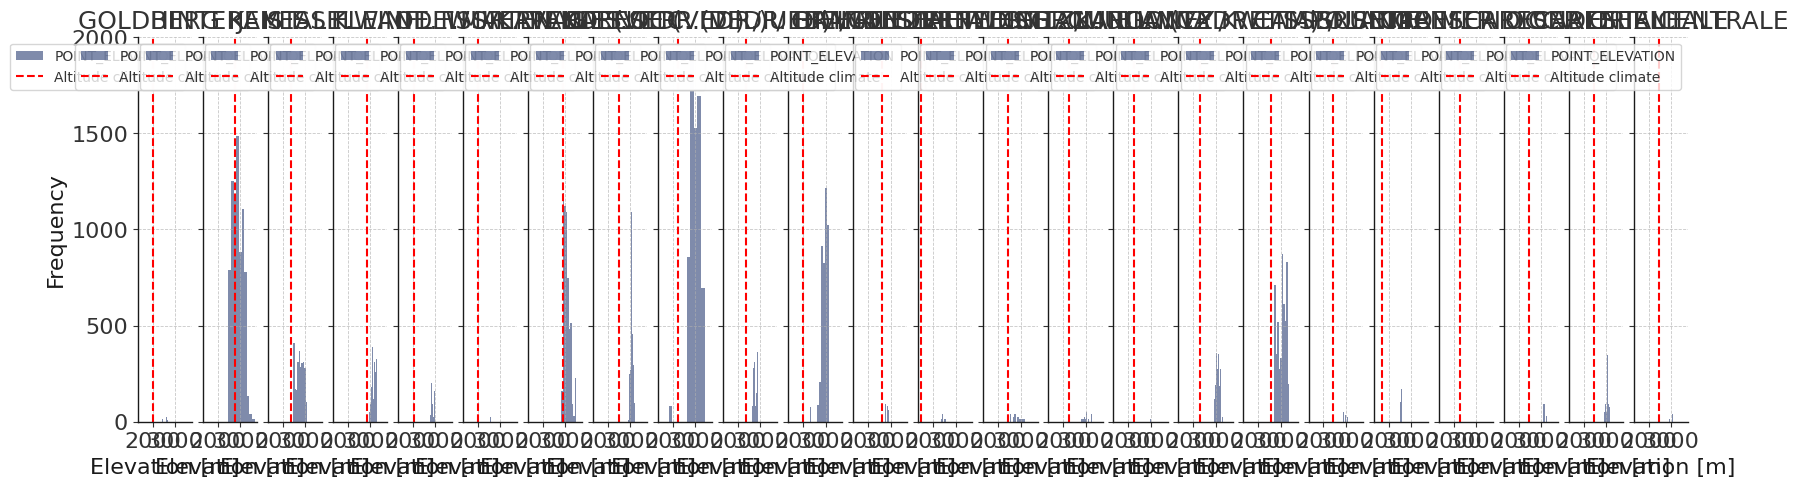

In [25]:
plotHeatmap(dataloader_gl.data, test_glaciers, period='annual')
#plotHeatmap(dataloader_gl.data, test_glaciers, period='winter')
visualiseSplits(test_set['y'], train_set['y'], splits)
visualiseInputs(train_set, test_set, vois_climate)

# Number of measurements per year:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
test_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[0])
ax[0].set_title('Number of measurements per year for test glaciers')

# Number of measurements per year:
train_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[1])
ax[1].set_title('Number of measurements per year for train glaciers')
plt.tight_layout()

f, ax = plt.subplots(1,
                     len(test_glaciers),
                     figsize=(20, 5),
                     sharey='row',
                     sharex='row')

for i, test_gl in enumerate(test_glaciers):
    test_df_gl = test_set['df_X'][test_set['df_X'].GLACIER == test_gl]
    test_df_gl.POINT_ELEVATION.plot.hist(color=color_dark_blue,
                                         alpha=0.5,
                                         density=False,
                                         ax=ax[i])
    # add vertical line for altitude climate
    alt_climate = test_df_gl.ALTITUDE_CLIMATE.mean()
    ax[i].axvline(x=alt_climate,
                  color='red',
                  linestyle='--',
                  label='Altitude climate')
    ax[i].set_xlabel('Elevation [m]')
    ax[i].legend()
    ax[i].set_title(test_gl)
plt.tight_layout()

#### B.2.2. XGBoost Transfer Region

In [26]:
# Grid search
# For each of the XGBoost parameter, define the grid range
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators':
    [50, 100, 200, 300, 400, 500, 600,
     700],  # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
}

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'gpu_hist'
param_init["random_state"] = cfg.seed
param_init["n_jobs"] = 1

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
]

#### Grid Search

In [28]:
%%time
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

RUN = True
if RUN:
    # Create a CustomXGBoostRegressor instance
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg, **param_init)
    custom_xgboost.randomsearch(
        parameters=param_grid,
        n_iter=45,
        splits=splits,
        features=df_X_train_subset,
        targets=train_set['y'],
    )

    # save best model
    custom_xgboost.save_model(f'xgb_CH_11_06_IT_AT.pkl')
else:
    # read model
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg)
    custom_xgboost.load_model(
        f'xgb_CH_11_06_IT_AT.pkl')

# Get best parameters and estimator
best_params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)

# Calculate scores
score = best_estimator_cpu.score(test_set['df_X'][all_columns],
                                 test_set['y'])  # negative
print('Overall score:', np.abs(score))

Shape of training dataset: (290682, 25)
Shape of testing dataset: (47883, 25)
Running with features: ['ELEVATION_DIFFERENCE', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness']
Fitting 5 folds for each of 45 candidates, totalling 225 fits


/home/mburlet/anaconda3/envs/MassBalanceMachine/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:31:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mburlet/anaconda3/envs/MassBalanceMachine/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:31:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "cfg" } are not used.

  warnings.warn(smsg, UserWarning)
/home/mburlet/anaconda3/envs/MassBalanceMachine/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:31:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mburlet/anaco

Best parameters:
 {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.01}
Best score:
 -0.1944065965918095
Shape of the test: (47883, 14)
Overall score: 1.1423767721348095
CPU times: user 4min 21s, sys: 4.81 s, total: 4min 26s
Wall time: 36min 38s


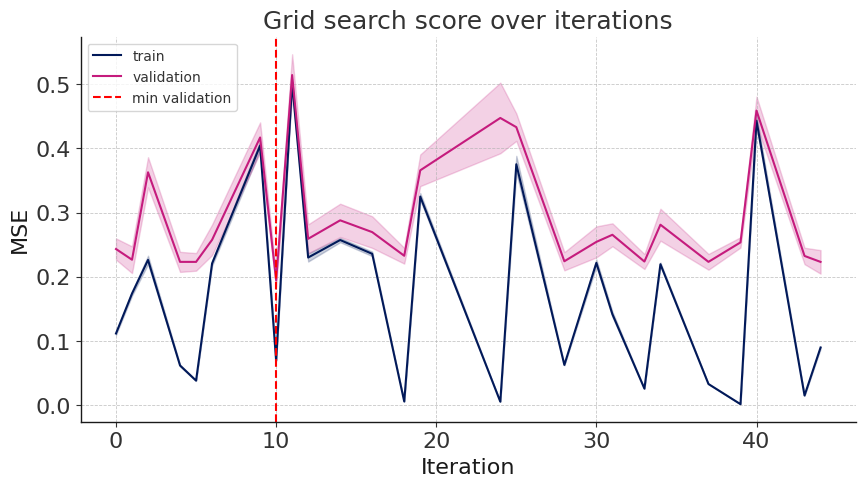

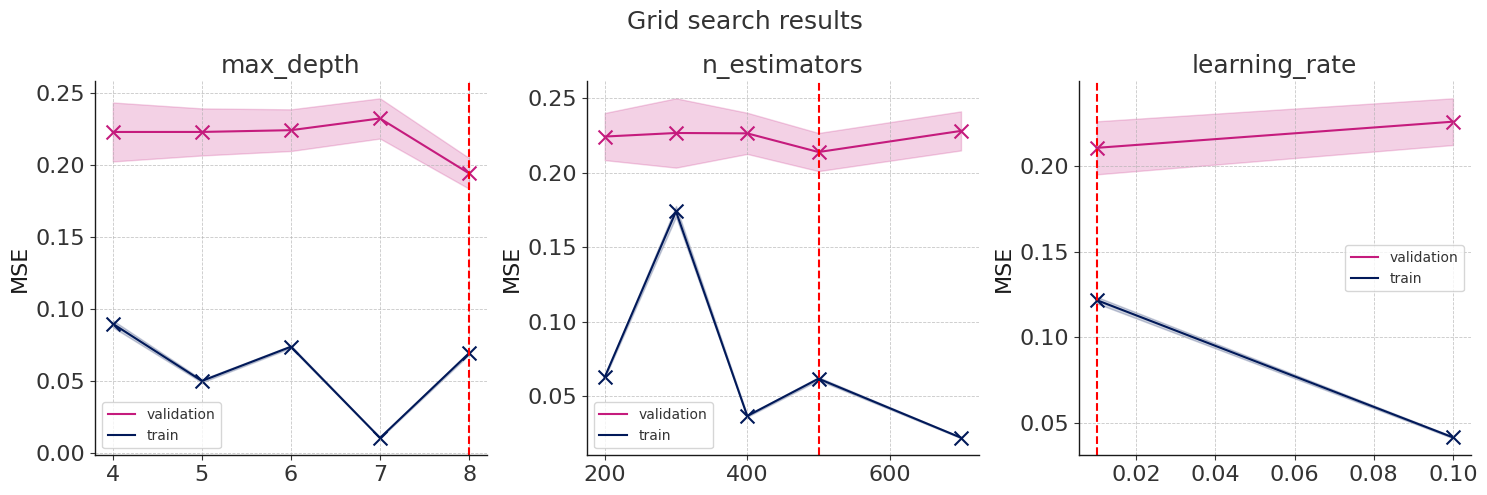

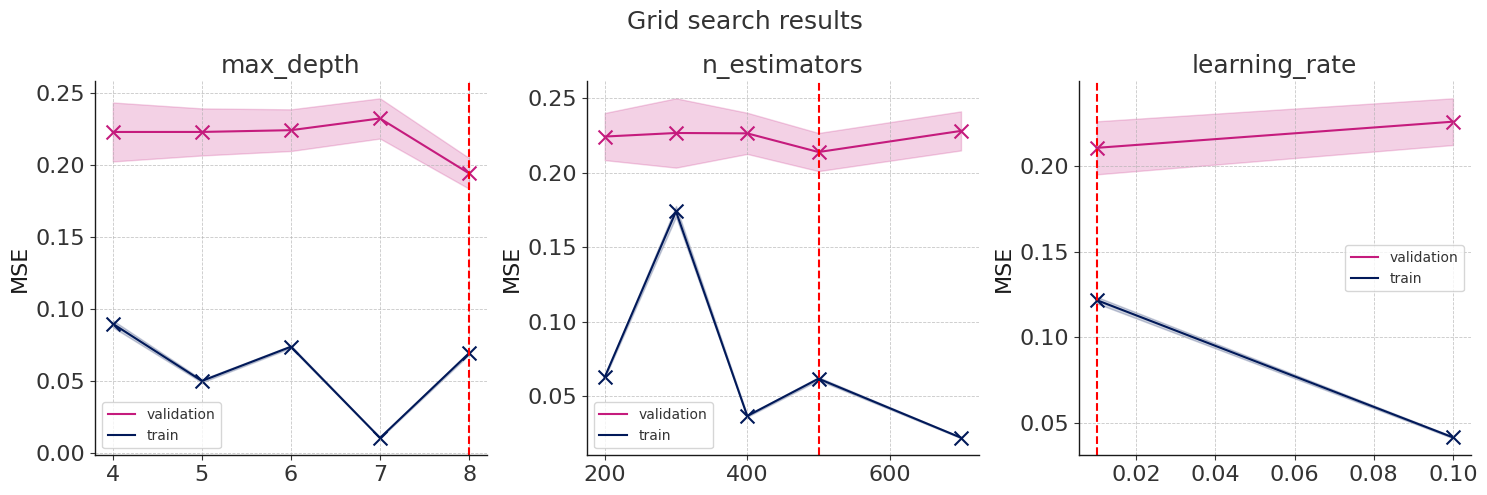

In [29]:
plotGridSearchScore(cv_results_=custom_xgboost.param_search.cv_results_,
                    lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss,
                     N=10)

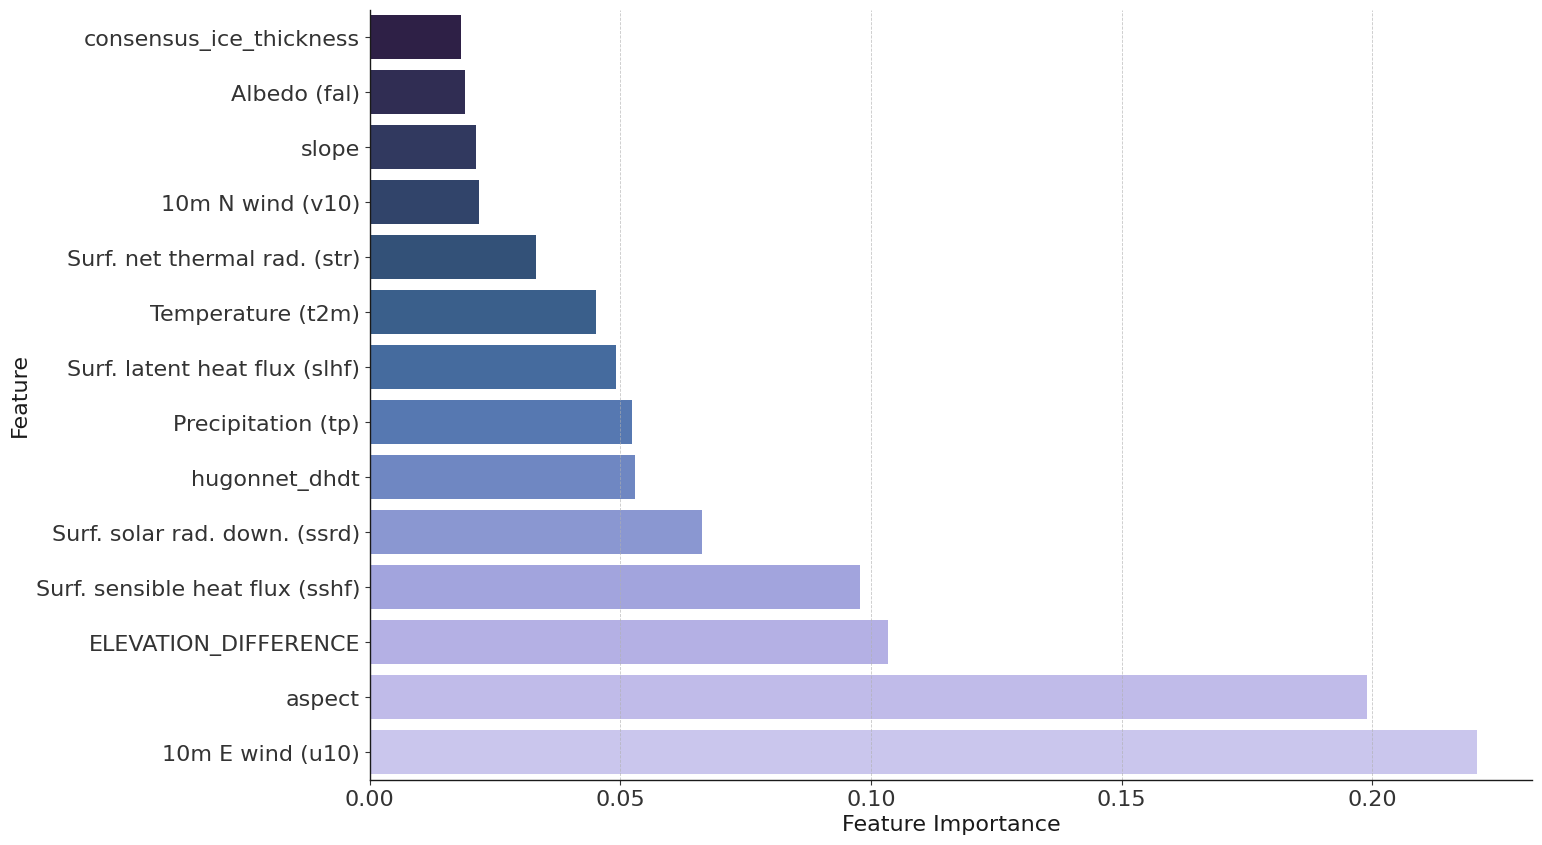

In [30]:
FIPlot(best_estimator, feature_columns, vois_climate)

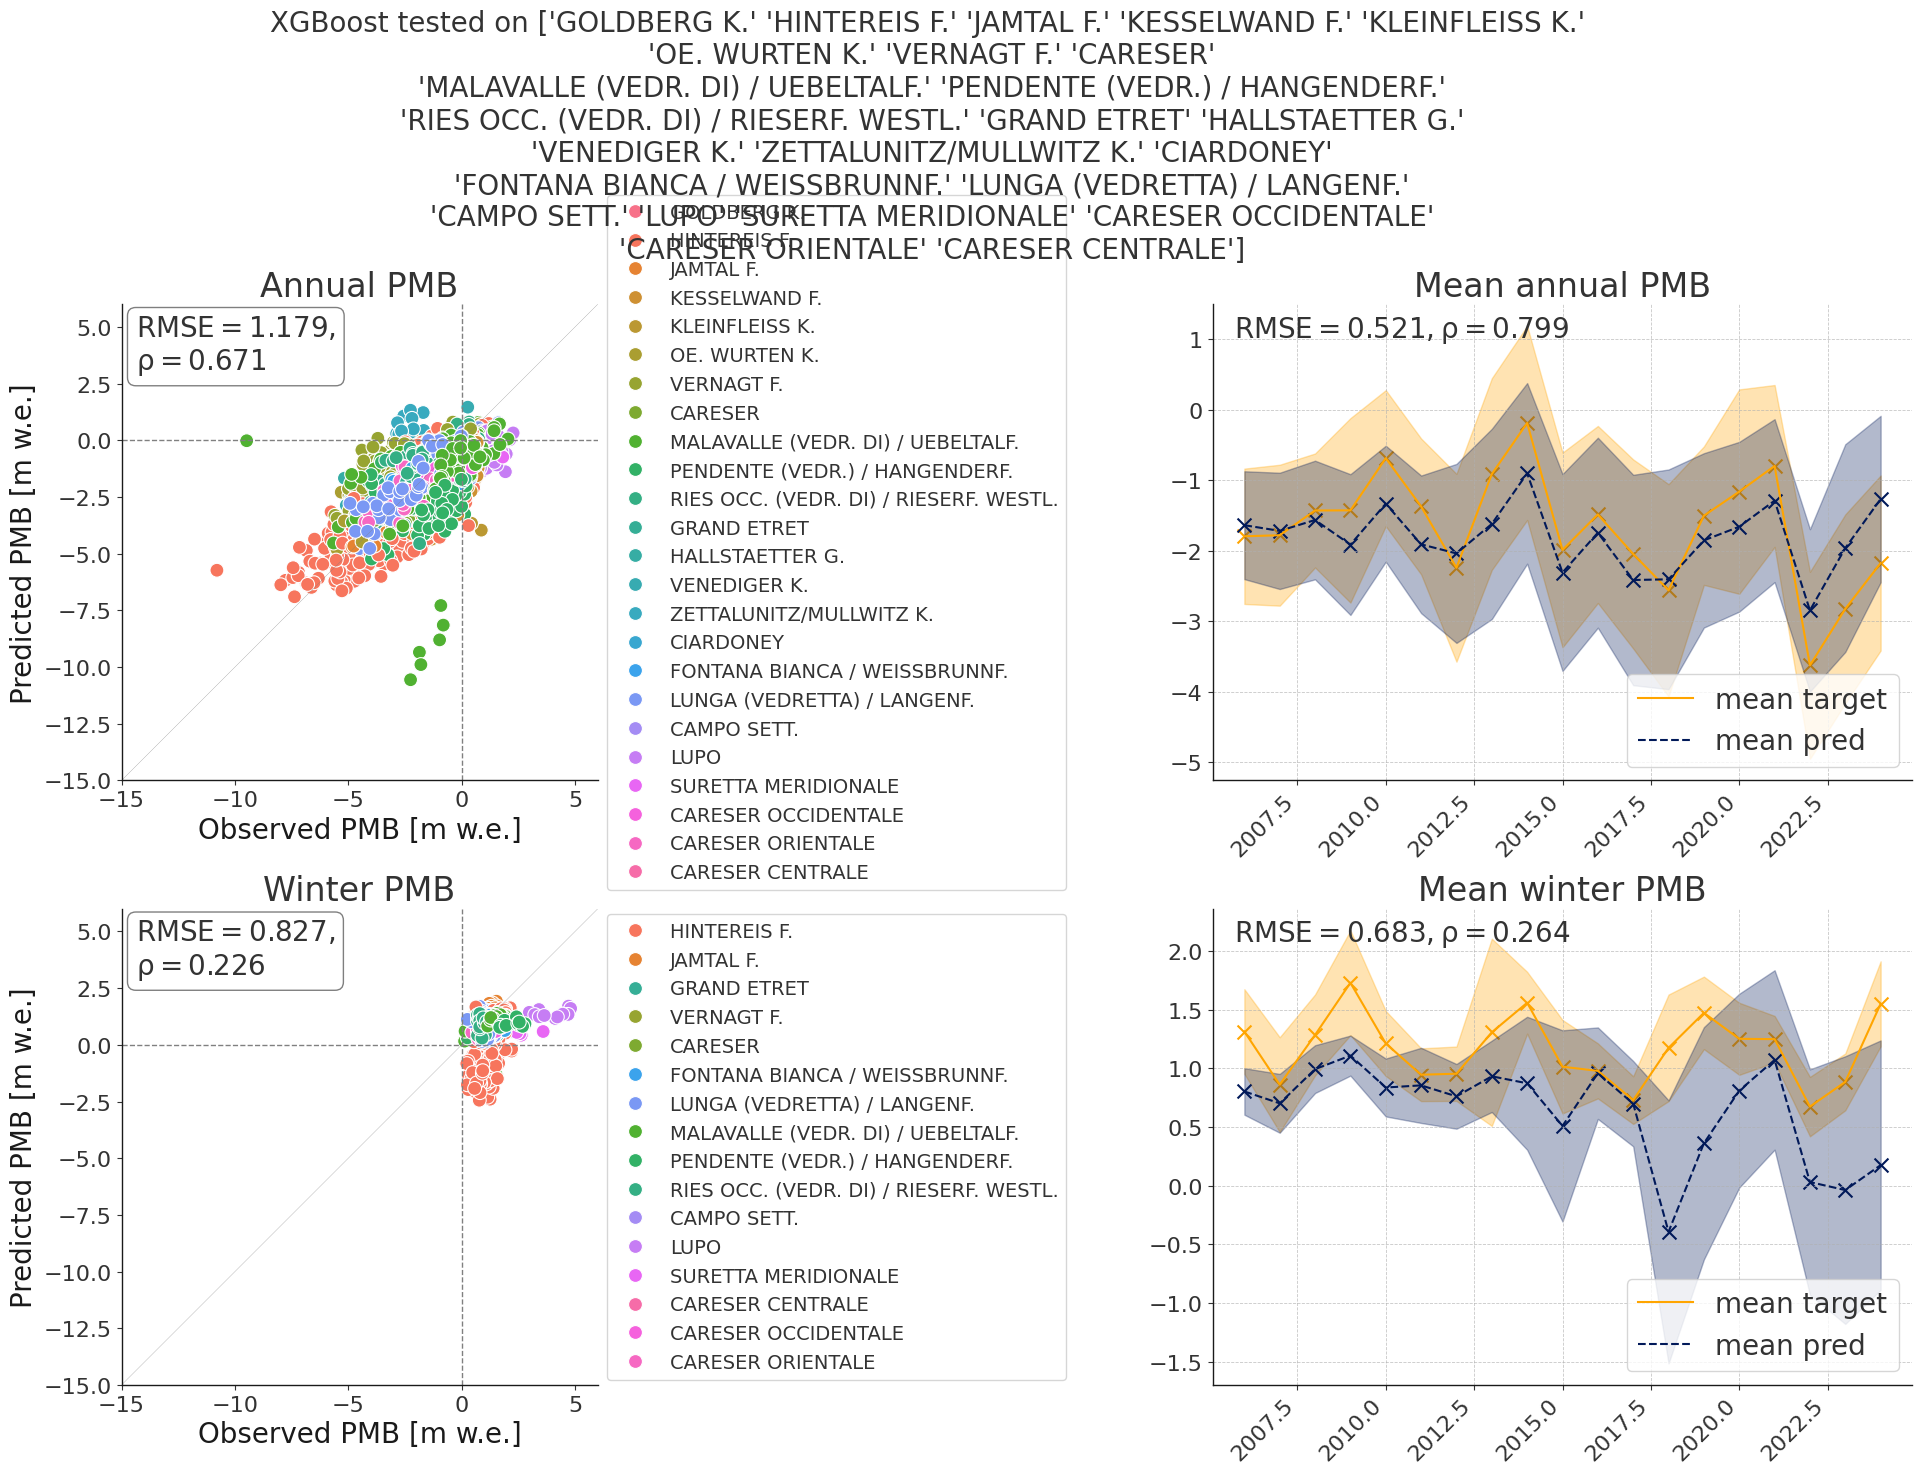

In [31]:
# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)

y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)
grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)


PlotPredictions(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu)
plt.suptitle(f'XGBoost tested on {test_set["splits_vals"]}', fontsize=20)
plt.tight_layout()

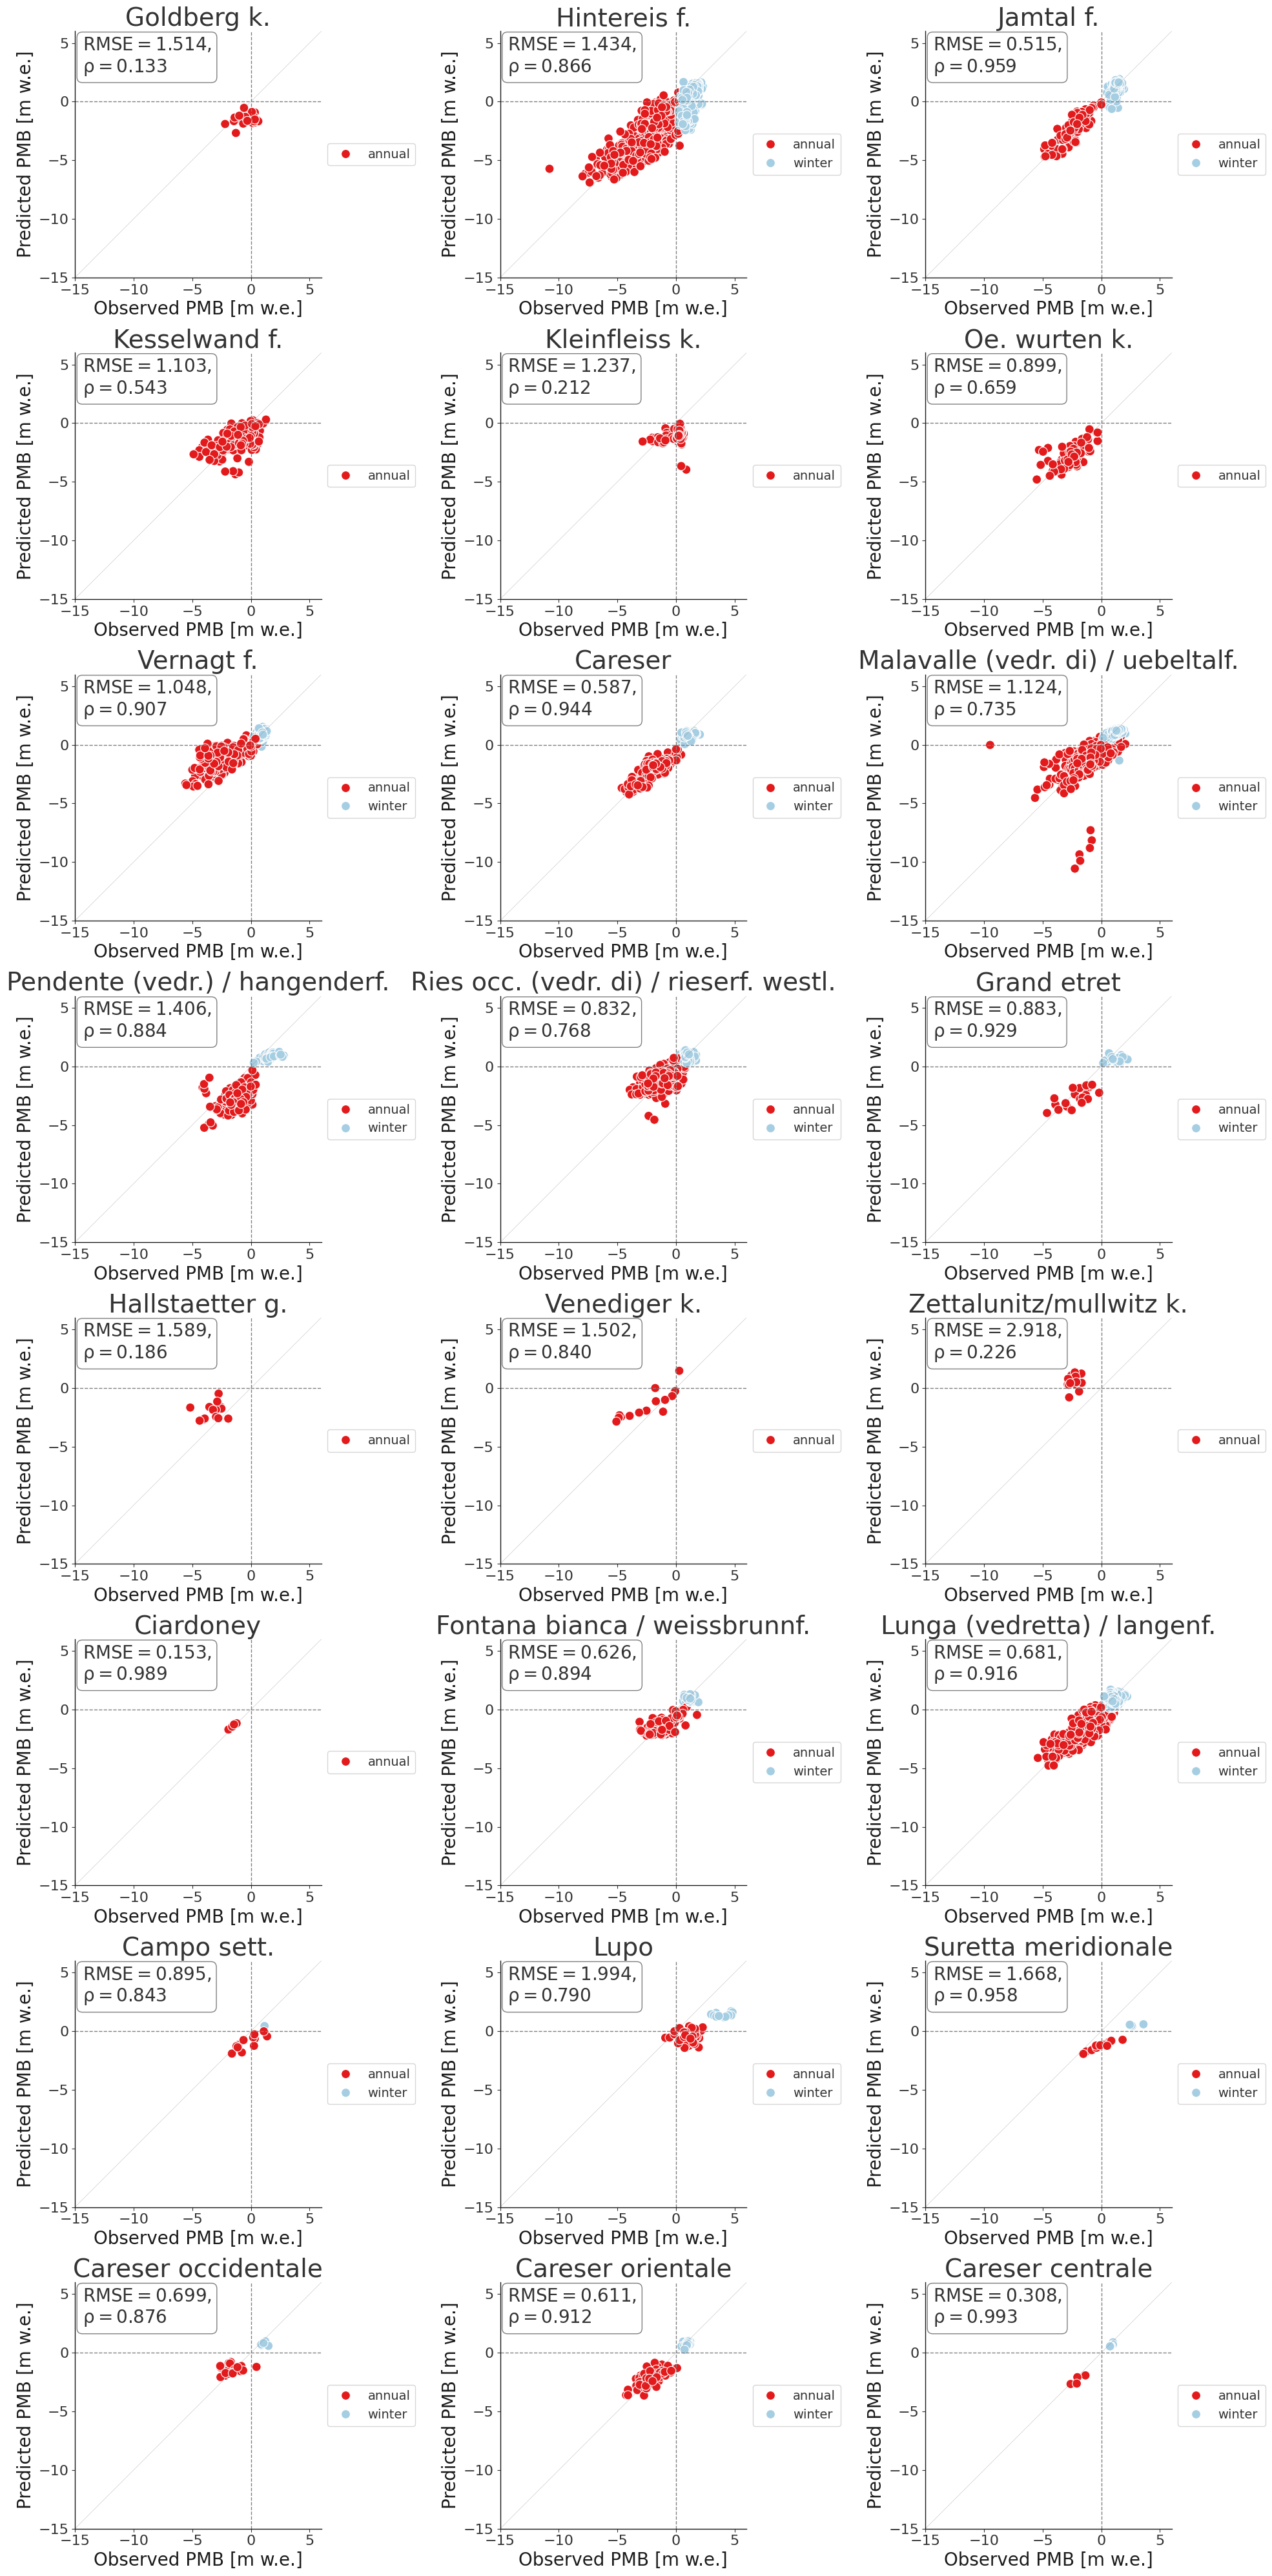

In [32]:
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))

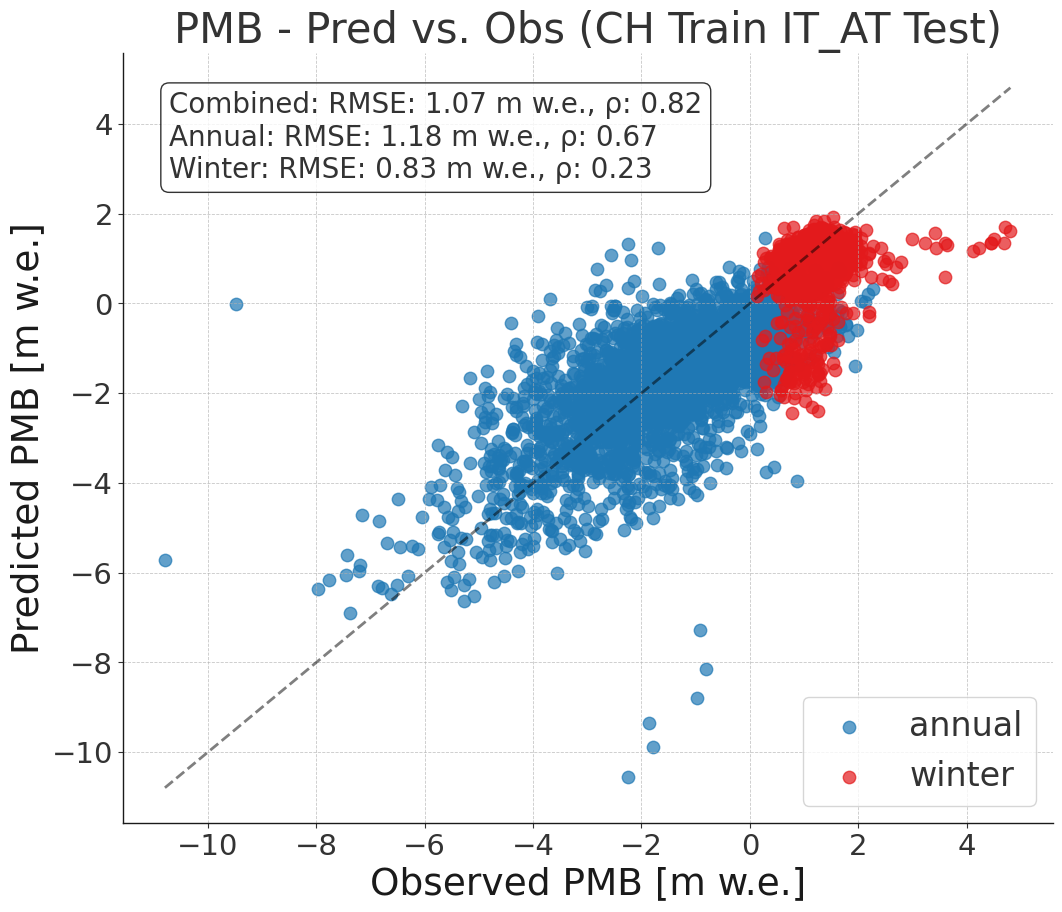

In [34]:
PlotPredictionsCombined(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu, region_name='CH Train IT_AT Test', include_summer = False)

In [35]:
display(grouped_ids[grouped_ids['target'] < -9])
display(data_monthly_CH_IT_AT[data_monthly_CH_IT_AT['POINT_ID']=='MALAVALLE (VEDR. DI) / UEBELTALF._2018_18115_IT'])
display(data_monthly_CH_IT_AT[data_monthly_CH_IT_AT['POINT_ID']=='HINTEREIS F._2018_15865_AT'])

# Get the specific stakes with extreme predictions
outlier_stakes = data_monthly_CH_IT_AT[(data_monthly_CH_IT_AT['GLACIER'] == 'GRAND ETRET') & 
                                       (data_monthly_CH_IT_AT['POINT_ID'].isin(['GRAND ETRET_2008_32398_IT', 
                                                                               'GRAND ETRET_2008_32396_IT']))]

# Display the outlier stakes data
display(outlier_stakes)

# Get all stakes from the same glacier for comparison
normal_stakes = data_monthly_CH_IT_AT[(data_monthly_CH_IT_AT['GLACIER'] == 'GRAND ETRET') & 
                                    (~data_monthly_CH_IT_AT['POINT_ID'].isin(['GRAND ETRET_2008_32398_IT', 
                                                                            'GRAND ETRET_2008_32396_IT']))]

display(normal_stakes['POINT_ID'].unique())

comparison_columns = ['ELEVATION_DIFFERENCE', 't2m', 'tp', 'slhf', 'sshf', 
                      'ssrd', 'fal', 'str', 'aspect', 'slope', 'hugonnet_dhdt', 
                      'consensus_ice_thickness', 'ALTITUDE_CLIMATE', 
                      'POINT_ELEVATION', 'POINT_BALANCE']

# Display statistics for outlier stakes
print("=== Outlier Stakes Statistics ===")
display(outlier_stakes[comparison_columns].describe())

# Display statistics for normal stakes
print("=== Normal Stakes Statistics ===")
display(normal_stakes[comparison_columns].describe())

# Check for extreme values in any of the features
for col in comparison_columns:
    if col in outlier_stakes.columns:
        outlier_values = outlier_stakes[col].values
        normal_range = normal_stakes[col].quantile([0.05, 0.95]).values
        
        if (outlier_values < normal_range[0]).any() or (outlier_values > normal_range[1]).any():
            print(f"Potential issue in {col}: Outliers outside 5-95% range of normal stakes")
            print(f"Outlier values: {outlier_values}")
            print(f"Normal range (5-95%): {normal_range}")
            print("---")

target  YEAR                                         POINT_ID  \
ID                                                                    
2863 -10.793  2018                       HINTEREIS F._2018_15865_AT   
3542  -9.480  2023  MALAVALLE (VEDR. DI) / UEBELTALF._2023_63204_IT   

                                GLACIER      pred  PERIOD  
ID                                                         
2863                       HINTEREIS F. -5.728770  annual  
3542  MALAVALLE (VEDR. DI) / UEBELTALF. -0.016493  annual

YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
32195  2018    11.1883    46.9486         -2.253       2106.907077   
32196  2018    11.1883    46.9486         -2.253       2106.907077   
32197  2018    11.1883    46.9486         -2.253       2106.907077   
32198  2018    11.1883    46.9486         -2.253       2106.907077   
32199  2018    11.1883    46.9486         -2.253       2106.907077   
32200  2018    11.1883    46.9486         -2.253       2106.907077   
32201  2018    11.1883    46.9486         -2.253       2106.907077   
32202  2018    11.1883    46.9486         -2.253       2106.907077   
32203  2018    11.1883    46.9486         -2.253       2106.907077   
32204  2018    11.1883    46.9486         -2.253       2106.907077   
32205  2018    11.1883    46.9486         -2.253       2106.907077   
32206  2018    11.1883    46.9486         -2.253       2106.907077   

       ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
32195           -294.907077           1812.0  RGI60-11.00597   
32196           -294.907077           1812.0  RGI60-11.00597   
32197           -294.907077           1812.0  RGI60-11.00597   
32198           -294.907077           1812.0  RGI60-11.00597   
32199           -294.907077           1812.0  RGI60-11.00597   
32200           -294.907077           1812.0  RGI60-11.00597   
32201           -294.907077           1812.0  RGI60-11.00597   
32202           -294.907077           1812.0  RGI60-11.00597   
32203           -294.907077           1812.0  RGI60-11.00597   
32204           -294.907077           1812.0  RGI60-11.00597   
32205           -294.907077           1812.0  RGI60-11.00597   
32206           -294.907077           1812.0  RGI60-11.00597   

                                              POINT_ID    ID  ...  \
32195  MALAVALLE (VEDR. DI) / UEBELTALF._2018_18115_IT  2958  ...   
32196  MALAVALLE (VEDR. DI) / UEBELTALF._2018_18115_IT  2958  ...   
32197  MALAVALLE (VEDR. DI) / UEBELTALF._2018_18115_IT  2958  ...   
32198  MALAVALLE (VEDR. DI) / UEBELTALF._2018_18115_IT  2958  ...   
32199  MALAVALLE (VEDR. DI) / UEBELTALF._2018_18115_IT  2958  ...   
32200  MALAVALLE (VEDR. DI) / UEBELTALF._2018_18115_IT  2958  ...   
32201  MALAVALLE (VEDR. DI) / UEBELTALF._2018_18115_IT  2958  ...   
32202  MALAVALLE (VEDR. DI) / UEBELTALF._2018_18115_IT  2958  ...   
32203  MALAVALLE (VEDR. DI) / UEBELTALF._2018_18115_IT  2958  ...   
32204  MALAVALLE (VEDR. DI) / UEBELTALF._2018_18115_IT  2958  ...   
32205  MALAVALLE (VEDR. DI) / UEBELTALF._2018_18115_IT  2958  ...   
32206  MALAVALLE (VEDR. DI) / UEBELTALF._2018_18115_IT  2958  ...   

       consensus_ice_thickness        t2m        tp       slhf       sshf  \
32195                127.05397   3.514313  0.002408 -2504406.0  -726108.0   
32196                127.05397  -5.065765  0.003797  -246372.0   -17402.0   
32197                127.05397  -9.617035  0.004759   103262.0   227746.0   
32198                127.05397  -6.673920  0.004374   145346.0    64488.0   
32199                127.05397 -10.268890  0.001854   -58024.0  -752379.0   
32200                127.05397  -4.859222  0.003724  -134516.0 -1475066.0   
32201                127.05397   2.418854  0.001960  -282764.0 -2290418.0   
32202                127.05397   5.931549  0.004013 -1894128.0 -2425444.0   
32203                127.05397   9.983551  0.004075 -7965278.0 -3952196.0   
32204                127.05397  11.945221  0.005751 -8387370.0 -3346080.0   
32205                127.05397  12.086334  0.007084 -7105212.0 -2320466.0   
32206                127.05397   9.203766  0.003074 -5581412.0 -2029792.0   

             ssrd       fal        str       u10       v10  
32195  10710260.0  0.255278 -4841550.0  0.449998 -0.413028  
32196   6464144.0  0.606407 -2668100.0  0.421263 -0.369674  
32197   5082384.0  0.650186 -2375462.0  0.568208 -0.353170  
32198   5949100.0  0.652911 -2545219.0  0.508013 -0.137403  
32199   9678248.0  0.639888 -3391602.0  0.214916 -0.480371

YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
30999  2018  10.789539  46.813913        -10.793       2835.655296   
31000  2018  10.789539  46.813913        -10.793       2835.655296   
31001  2018  10.789539  46.813913        -10.793       2835.655296   
31002  2018  10.789539  46.813913        -10.793       2835.655296   
31003  2018  10.789539  46.813913        -10.793       2835.655296   
31004  2018  10.789539  46.813913        -10.793       2835.655296   
31005  2018  10.789539  46.813913        -10.793       2835.655296   
31006  2018  10.789539  46.813913        -10.793       2835.655296   
31007  2018  10.789539  46.813913        -10.793       2835.655296   
31008  2018  10.789539  46.813913        -10.793       2835.655296   
31009  2018  10.789539  46.813913        -10.793       2835.655296   
31010  2018  10.789539  46.813913        -10.793       2835.655296   
31011  2018  10.789539  46.813913        -10.793       2835.655296   

       ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
30999           -332.655296           2503.0  RGI60-11.00897   
31000           -332.655296           2503.0  RGI60-11.00897   
31001           -332.655296           2503.0  RGI60-11.00897   
31002           -332.655296           2503.0  RGI60-11.00897   
31003           -332.655296           2503.0  RGI60-11.00897   
31004           -332.655296           2503.0  RGI60-11.00897   
31005           -332.655296           2503.0  RGI60-11.00897   
31006           -332.655296           2503.0  RGI60-11.00897   
31007           -332.655296           2503.0  RGI60-11.00897   
31008           -332.655296           2503.0  RGI60-11.00897   
31009           -332.655296           2503.0  RGI60-11.00897   
31010           -332.655296           2503.0  RGI60-11.00897   
31011           -332.655296           2503.0  RGI60-11.00897   

                         POINT_ID    ID  ...  consensus_ice_thickness  \
30999  HINTEREIS F._2018_15865_AT  2863  ...               115.586075   
31000  HINTEREIS F._2018_15865_AT  2863  ...               115.586075   
31001  HINTEREIS F._2018_15865_AT  2863  ...               115.586075   
31002  HINTEREIS F._2018_15865_AT  2863  ...               115.586075   
31003  HINTEREIS F._2018_15865_AT  2863  ...               115.586075   
31004  HINTEREIS F._2018_15865_AT  2863  ...               115.586075   
31005  HINTEREIS F._2018_15865_AT  2863  ...               115.586075   
31006  HINTEREIS F._2018_15865_AT  2863  ...               115.586075   
31007  HINTEREIS F._2018_15865_AT  2863  ...               115.586075   
31008  HINTEREIS F._2018_15865_AT  2863  ...               115.586075   
31009  HINTEREIS F._2018_15865_AT  2863  ...               115.586075   
31010  HINTEREIS F._2018_15865_AT  2863  ...               115.586075   
31011  HINTEREIS F._2018_15865_AT  2863  ...               115.586075   

             t2m        tp      slhf      sshf        ssrd       fal  \
30999   4.084625  0.002614    3228.0   54434.0  15406734.0  0.841343   
31000  -1.138031  0.001870  -13428.0  120112.0  11208426.0  0.841338   
31001 -10.020844  0.003271    4186.0   40774.0   7403736.0  0.841422   
31002 -14.724457  0.003749   27812.0  112402.0   5609468.0  0.841470   
31003 -12.185638  0.004356   29592.0   94426.0   6526636.0  0.841464   
31004 -15.516937  0.001398    8134.0   47639.0  10644328.0  0.841471   
31005 -10.245941  0.002615  -53108.0  -16026.0  15740499.0  0.841451   
31006  -2.317474  0.001305 -121536.0  -36340.0  22524218.0  0.841435   
31007   0.507721  0.003323 -218936.0 -216448.0  21141524.0  0.841404   
31008   4.032379  0.003842  -26188.0   -3738.0  21966728.0  0.841341   
31009   6.017487  0.003218   20274.0   52180.0  21435408.0  0.841333   
31010   6.482819  0.006340   67412.0   49202.0  17644546.0  0.841341   
31011   4.084625  0.002614    3228.0   54434.0  15406734.0  0.841343   

             str       u10       v10  
30999 -1780278.0  0.179548 -0.232630  
31000 -2331074.0  0

YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
41852  2008     7.2191  45.477501         -1.279       2622.991033   
41853  2008     7.2191  45.477501         -1.279       2622.991033   
41854  2008     7.2191  45.477501         -1.279       2622.991033   
41855  2008     7.2191  45.477501         -1.279       2622.991033   
41856  2008     7.2191  45.477501         -1.279       2622.991033   
41857  2008     7.2191  45.477501         -1.279       2622.991033   
41858  2008     7.2191  45.477501         -1.279       2622.991033   
41859  2008     7.2191  45.477501         -1.279       2622.991033   
41860  2008     7.2191  45.477501         -1.279       2622.991033   
41861  2008     7.2191  45.477501         -1.279       2622.991033   
41862  2008     7.2191  45.477501         -1.279       2622.991033   
41863  2008     7.2191  45.477501         -1.279       2622.991033   
41864  2008     7.2191  45.477501         -1.279       2622.991033   
41865  2008     7.2200  45.480801         -2.427       2622.991033   
41866  2008     7.2200  45.480801         -2.427       2622.991033   
41867  2008     7.2200  45.480801         -2.427       2622.991033   
41868  2008     7.2200  45.480801         -2.427       2622.991033   
41869  2008     7.2200  45.480801         -2.427       2622.991033   
41870  2008     7.2200  45.480801         -2.427       2622.991033   
41871  2008     7.2200  45.480801         -2.427       2622.991033   
41872  2008     7.2200  45.480801         -2.427       2622.991033   
41873  2008     7.2200  45.480801         -2.427       2622.991033   
41874  2008     7.2200  45.480801         -2.427       2622.991033   
41875  2008     7.2200  45.480801         -2.427       2622.991033   
41876  2008     7.2200  45.480801         -2.427       2622.991033   
41877  2008     7.2200  45.480801         -2.427       2622.991033   

       ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
41852            257.008967           2880.0  RGI60-11.03166   
41853            257.008967           2880.0  RGI60-11.03166   
41854            257.008967           2880.0  RGI60-11.03166   
41855            257.008967           2880.0  RGI60-11.03166   
41856            257.008967           2880.0  RGI60-11.03166   
41857            257.008967           2880.0  RGI60-11.03166   
41858            257.008967           2880.0  RGI60-11.03166   
41859            257.008967           2880.0  RGI60-11.03166   
41860            257.008967           2880.0  RGI60-11.03166   
41861            257.008967           2880.0  RGI60-11.03166   
41862            257.008967           2880.0  RGI60-11.03166   
41863            257.008967           2880.0  RGI60-11.03166   
41864            257.008967           2880.0  RGI60-11.03166   
41865            157.008967           2780.0  RGI60-11.03166   
41866            157.008967           2780.0  RGI60-11.03166   
41867            157.008967           2780.0  RGI60-11.03166   
41868            157.008967           2780.0  RGI60-11.03166   
41869            157.008967           2780.0  RGI60-11.03166   
41870            157.008967           2780.0  RGI60-11.03166   
41871            157.008967           2780.0  RGI60-11.03166   
41872            157.008967           2780.0  RGI60-11.03166   
41873            157.008967           2780.0  RGI60-11.03166   
41874            157.008967           2780.0  RGI60-11.03166   
41875            157.008967           2780.0  RGI60-11.03166   
41876            157.008967           2780.0  RGI60-11.03166   
41877            157.008967           2780.0  RGI60-11.03166   

                        POINT_ID    ID  ...  consensus_ice_thickness  \
41852  GRAND ETRET_2008_32398_IT  3828  ...                40.698696   
41853  GRAND ETRET_2008_32398_IT  3828  ...                40.698696   
41854  GRAND ETRET_2008_32398_IT  3828  ...                40.698696   
41855  GRAND ETRET_2008_32398_IT  3828  ...                40.698696   
41856  GRAND ETRET_2008_323

array(['GRAND ETRET_2021_47035_IT', 'GRAND ETRET_2021_47037_IT',
       'GRAND ETRET_2021_47039_IT', 'GRAND ETRET_2021_47040_IT',
       'GRAND ETRET_2021_47042_IT', 'GRAND ETRET_2021_47044_IT',
       'GRAND ETRET_2024_63131_IT', 'GRAND ETRET_2024_63132_IT',
       'GRAND ETRET_2024_63133_IT', 'GRAND ETRET_2024_63134_IT',
       'GRAND ETRET_2024_63135_IT', 'GRAND ETRET_2024_63136_IT',
       'GRAND ETRET_2024_63138_IT', 'GRAND ETRET_2024_63139_IT',
       'GRAND ETRET_2024_63140_IT', 'GRAND ETRET_2024_63137_IT',
       'GRAND ETRET_2022_47047_IT', 'GRAND ETRET_2022_47046_IT',
       'GRAND ETRET_2022_47045_IT', 'GRAND ETRET_2022_47048_IT',
       'GRAND ETRET_2022_47049_IT', 'GRAND ETRET_2022_47051_IT',
       'GRAND ETRET_2022_47053_IT', 'GRAND ETRET_2022_47052_IT',
       'GRAND ETRET_2022_47054_IT', 'GRAND ETRET_2022_47050_IT',
       'GRAND ETRET_2023_51760_IT', 'GRAND ETRET_2023_51759_IT',
       'GRAND ETRET_2023_51757_IT', 'GRAND ETRET_2023_51758_IT',
       'GRAND ETRET_2023_

=== Outlier Stakes Statistics ===


ELEVATION_DIFFERENCE        t2m         tp          slhf          sshf  \
count             26.000000  26.000000  26.000000  2.600000e+01  2.600000e+01   
mean             207.008967  -1.136679   0.004251 -2.578337e+06 -1.226111e+06   
std               50.990195   6.482986   0.001848  2.894538e+06  1.422493e+06   
min              157.008967 -11.043549   0.000853 -7.908382e+06 -3.568062e+06   
25%              157.008967  -7.220795   0.003146 -4.305036e+06 -2.423888e+06   
50%              207.008967   0.539215   0.004967 -4.822460e+05 -3.066240e+05   
75%              257.008967   3.453766   0.005347 -3.941020e+05 -9.451400e+04   
max              257.008967   8.044586   0.007011  2.180800e+04  2.197340e+05   

               ssrd        fal           str      aspect      slope  \
count  2.600000e+01  26.000000  2.600000e+01   26.000000  26.000000   
mean   1.458294e+07   0.498891 -3.751224e+06  174.817876  17.614315   
std    5.399049e+06   0.287010  1.515882e+06  166.716735   1.406398   
min    6.436060e+06   0.162035 -6.273684e+06   11.338667  16.235228   
25%    1.100811e+07   0.197803 -4.899386e+06   11.338667  16.235228   
50%    1.438839e+07   0.597389 -3.389126e+06  174.817876  17.614315   
75%    1.972797e+07   0.793619 -2.805716e+06  338.297084  18.993402   
max    2.229192e+07   0.839557 -1.509491e+06  338.297084  18.993402   

       hugonnet_dhdt  consensus_ice_thickness  ALTITUDE_CLIMATE  \
count      26.000000                26.000000      2.600000e+01   
mean       -1.394955                27.847932      2.622991e+03   
std         0.183815                13.105259      1.391259e-12   
min        -1.575200                14.997169      2.622991e+03   
25%        -1.575200                14.997169      2.622991e+03   
50%        -1.394955                27.847932      2.622991e+03   
75%        -1.214709                40.698696      2.622991e+03   
max        -1.214709                40.698696      2.622991e+03   

       POINT_ELEVATION  POINT_BALANCE  
count        26.000000      26.000000  
mean       2830.000000      -1.853000  
std          50.990195       0.585367  
min        2780.000000      -2.427000  
25%        2780.000000      -2.427000  
50%        2830.000000      -1.853000  
75%        2880.000000      -1.279000  
max        2880.000000      -1.279000

=== Normal Stakes Statistics ===


ELEVATION_DIFFERENCE         t2m          tp          slhf  \
count            373.000000  373.000000  373.000000  3.730000e+02   
mean             254.614865   -2.238264    0.003238 -1.407372e+06   
std              100.221248    6.340964    0.002205  2.284303e+06   
min              120.008967  -12.640717    0.000488 -8.891288e+06   
25%              177.008967   -7.309662    0.001816 -1.341055e+06   
50%              237.008967   -3.717133    0.002983 -2.812530e+05   
75%              278.008967    3.202301    0.004075 -2.314200e+04   
max              412.008967   10.780914    0.009996  2.406200e+04   

               sshf          ssrd         fal           str      aspect  \
count  3.730000e+02  3.730000e+02  373.000000  3.730000e+02  373.000000   
mean  -6.066035e+05  1.161559e+07    0.604501 -2.578623e+06  111.951623   
std    1.055979e+06  6.502567e+06    0.271768  1.539278e+06  150.869879   
min   -3.577846e+06  3.189680e+06    0.154636 -6.966320e+06    8.475222   
25%   -7.806620e+05  5.880089e+06    0.257311 -3.382250e+06    8.651436   
50%   -9.681800e+04  1.081793e+07    0.755313 -2.206981e+06   11.338667   
75%    6.841200e+04  1.877404e+07    0.822551 -1.317688e+06  323.413555   
max    3.233000e+05  2.428793e+07    0.854556 -6.829920e+05  349.699675   

            slope  hugonnet_dhdt  consensus_ice_thickness  ALTITUDE_CLIMATE  \
count  373.000000     373.000000               373.000000      3.730000e+02   
mean    18.084340      -1.244834                37.201944      2.622991e+03   
std      3.544528       0.550538                 6.385604      1.730361e-11   
min     13.394011      -1.961211                14.997169      2.622991e+03   
25%     15.054949      -1.646559                33.298203      2.622991e+03   
50%     16.235228      -1.417180                40.308567      2.622991e+03   
75%     21.181093      -1.082793                41.766796      2.622991e+03   
max     22.845572      -0.230751                42.718555      2.622991e+03   

       POINT_ELEVATION  POINT_BALANCE  
count       373.000000     373.000000  
mean       2877.605898      -0.950764  
std         100.221248       1.982762  
min        2743.000000      -4.628000  
25%        2800.000000      -2.523000  
50%        2860.000000      -1.142000  
75%        2901.000000       0.974000  
max        3035.000000       2.240000

Potential issue in t2m: Outliers outside 5-95% range of normal stakes
Outlier values: [  3.45376587   0.66445923  -5.90512085 -11.04354858  -7.84164429
  -7.22079468  -7.86972046  -4.8465271    0.53921509   5.94204712
   7.85269165   8.04458618   3.45376587   3.45376587   0.66445923
  -5.90512085 -11.04354858  -7.84164429  -7.22079468  -7.86972046
  -4.8465271    0.53921509   5.94204712   7.85269165   8.04458618
   3.45376587]
Normal range (5-95%): [-9.93978882  9.47085571]
---
Potential issue in slhf: Outliers outside 5-95% range of normal stakes
Outlier values: [-4305036. -2232830.  -422602.    21808.    18104.   -45028.  -394102.
  -482246.  -430120. -5855514. -7908382. -7177398. -4305036. -4305036.
 -2232830.  -422602.    21808.    18104.   -45028.  -394102.  -482246.
  -430120. -5855514. -7908382. -7177398. -4305036.]
Normal range (5-95%): [-7452288.    19012.]
---
Potential issue in sshf: Outliers outside 5-95% range of normal stakes
Outlier values: [-2423888. -1456234.  -306624.

### Predictions of custom parameters:

In [ ]:
custom_params = {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 800}

# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

params = {**param_init, **custom_params}
print(params)
custom_model = mbm.models.CustomXGBoostRegressor(cfg, **params)

# Fit on train data:
custom_model.fit(train_set['df_X'][all_columns], train_set['y'])

# Make predictions on test
custom_model = custom_model.set_params(device='cpu')
features_test, metadata_test = custom_model._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = custom_model.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = custom_model.aggrPredict(metadata_test, features_test)

# Calculate scores
score = custom_model.score(test_set['df_X'][all_columns],
                           test_set['y'])  # negative
print('Overall score:', np.abs(score))

grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set, custom_model)
plt.suptitle(f'MBM tested on {test_set["splits_vals"]}', fontsize=20)
plt.tight_layout()

# Aggregate predictions to annual or winter:
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))

FIPlot(custom_model, feature_columns, vois_climate)